In [2]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os, sys
import json
import torch
import argparse
import gc
import time
import glob
import random
import ssl
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column
from astropy.nddata import Cutout2D

# Detectron setup
import detectron2.utils.comm as comm
from detectron2.utils.logger import setup_logger
setup_logger() # Setup detectron2 logger
from detectron2.config import LazyConfig, get_cfg
from detectron2.engine import launch
# for evaluating model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import deepdisc.astrodet.astrodet as toolkit
import detectron2.data as d2data
# for getting precision and recall
from detectron2 import structures
from detectron2.structures import BoxMode

# deepdisc imports
from deepdisc.data_format.image_readers import RomanImageReader
from deepdisc.data_format.register_data import register_data_set
from deepdisc.inference.predictors import return_predictor_transformer, get_predictions
from deepdisc.astrodet.visualizer import Visualizer
from deepdisc.astrodet.visualizer import ColorMode
from astropy.visualization import make_lupton_rgb
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Utils to analyze model
from plot_eval_utils import plot_losses, plot_det_gt, evaluate_model, plot_ap, get_pr

from astropy.io import fits

/home/yse2/.conda/envs/deepdisc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# needed to handle the WCS because we have upsampled annotations that we need to scale down for the WCS since the 
# WCS hasn't been scaled for the upsampled image and exists only for the small LSST img
def get_scale_factors(orig_height, orig_width):
    scale_x = orig_width / 512 
    scale_y = orig_height / 512
    return scale_x, scale_y

def adjust_coordinates(x, y, scale_x, scale_y):
    return x * scale_x, y * scale_y  # scaling down

def img_key_mapper(dataset_dict):
    """Map image keys from dataset dictionary.

    Args:
        dataset_dict (dict): Dataset dictionary containing file information

    Returns:
        str: File name from the dictionary
    """
    return dataset_dict["file_name"]

class ModelEvaluator:
    def __init__(self, run_dir, output_dir, test_data_file, cfg_file):
        """Initialize the ModelEvaluator.
        Args:
            run_dir (str): Directory containing model checkpoints
            output_dir (str): Directory for evaluation outputs
            test_data_file (str): Path to test data JSON file
            cfg_file (str): Path to model config file
        """
        self.run_dir = run_dir
        self.output_dir = output_dir
        self.test_data_file = test_data_file
        self.cfg_file = cfg_file
        self.imreader = RomanImageReader()
        
        # default params
        self.topk_per_img = 2000
        self.score_thresh = 0.3
        self.nms_thresh = 0.4
        
        self.cfg = None
        self.predictor = None
        self.test_data = None
        self.registered_test_data = None
        


    def set_thresholds(self, topk=None, score=None, nms=None):
        """Set detection thresholds.
        
        Args (Defaults set in instantiation):
            topk (int): Top-k predictions per image. 
            score (float): Score threshold
            nms (float): NMS threshold
        """
        if topk is not None:
            self.topk_per_img = topk
        if score is not None:
            self.score_thresh = score
        if nms is not None:
            self.nms_thresh = nms

    def load_model(self):
        """Load model configuration and checkpoint."""
        # finding model checkpoint
        pth_files = glob.glob(os.path.join(self.run_dir, '*.pth'))
        model_path = None
        for pth in pth_files:
            if "instances" not in pth:
                model_path = pth
                break
                
        if not model_path:
            raise ValueError(f"No valid checkpoint file found in {self.run_dir}")
            
        print(f"Using checkpoint file: {model_path}")
        
        # loading config
        print(f"\nLoading configs from {self.cfg_file}...")
        self.cfg = LazyConfig.load(self.cfg_file)
        for key in self.cfg.get("MISC", dict()).keys():
            self.cfg[key] = self.cfg.MISC[key]
            
        # model params
        self.cfg.train.init_checkpoint = model_path
        for box_predictor in self.cfg.model.roi_heads.box_predictors:
            box_predictor.test_topk_per_image = self.topk_per_img
            box_predictor.test_score_thresh = self.score_thresh
            box_predictor.test_nms_thresh = self.nms_thresh
            
        # initialize predictor
        self.predictor = return_predictor_transformer(self.cfg)
    
    def load_test_data(self):
        """Load and register test dataset."""
        print(f"\nLoading test data from {self.test_data_file}...")
        with open(self.test_data_file, 'r') as f:
            self.test_data = json.load(f)
            
        try:
            custom_colors = [
                (0, 255, 0),    # green for galaxies
                (0, 0, 255),    # blue for stars
            ]
            self.registered_test_data = register_data_set('test', 
                            self.test_data_file, 
                            thing_classes=["galaxy", "star"]).set(thing_colors=custom_colors)
        except AssertionError:
            print("\nTest dataset already registered")
    
    def get_test_data(self):
        if not self.test_data:
            raise ValueError("Load in the test data and register the dataset first! You can use load_test_data().")
        return self.test_data
    
    def evaluate(self):
        """Evaluate model performance on test dataset.
        
        Returns:
            dict: Evaluation results
        """
        if not all([self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first.")
            
        mapper = self.cfg.dataloader.train.mapper(
            self.cfg.dataloader.imagereader, 
            img_key_mapper
        ).map_data
        
        evaluator = toolkit.COCOEvaluatorRecall(
            'test',
            use_fast_impl=True,
            output_dir=self.output_dir,
            allow_cached_coco=False
        )
        
        eval_loader = d2data.build_detection_test_loader(
            self.cfg,
            'test',
            mapper=mapper
        )
        
        results = inference_on_dataset(
            self.predictor.model,
            eval_loader,
            evaluator
        )
        
        return results
    
    
    def get_predictions(self, scale=False):
        """Uses model to predict on the test data 
        
        Args:
            scale (boolean): Default is false since the WCS is for the smaller images. But, we need this to be able to scale up the RAs and DECs accordingly for the upsampled images
        
        Returns:
            predictions (dict): A catalog containing RAs, DECs of every predicted object along with the filenames, imgid and subpatch
        """
        if not all([self.imreader, self.test_data, self.cfg, self.predictor]):
            raise ValueError("Model not loaded. Call load_model() first. \
                             OR ModelEvaluator not instantiated. Create an ModelEvaluator object first \
                             OR Load in test data using load_test_data()")    
        pred_ras = []
        pred_decs = []
        imgids = []
        subpatches = []
        filenames = []

        truth_info_cache = {}
        for d in self.test_data:
            imid = d['image_id']
            filename = d['file_name']
            # temporary sol before I move all the corresponding correct WCS to the ups and pad dirs
            # right now only the truth dir has the updated WCS
            subpatch = d['subpatch']
            if subpatch not in truth_info_cache:
                truth_info_filename = f'./lsst_data/truth/{subpatch}/{subpatch}_info.json'
                with open(truth_info_filename) as json_data:
                    truth_info_cache[subpatch] = json.load(json_data)

            truth_info = truth_info_cache[subpatch]
            # grab the WCS
            entry = next(entry for entry in truth_info if entry['image_id'] == imid)
            wcs = WCS(entry['wcs'])
            if scale:
                orig_height, orig_width = entry['height'], entry['width']
                scale_x, scale_y = get_scale_factors(orig_height, orig_width)
            # print(wcs)

            # grab model's predictions
            outputs = get_predictions(d, self.imreader, img_key_mapper, self.predictor)
            centers_pred = outputs['instances'].pred_boxes.get_centers().cpu().numpy()
            if scale:
                adj_centers_pred = np.array([adjust_coordinates(x, y, scale_x, scale_y) for x, y in centers_pred])
                pred_coords = wcs.pixel_to_world(adj_centers_pred[:,0], adj_centers_pred[:,1])
            else:
                pred_coords = wcs.pixel_to_world(centers_pred[:,0],centers_pred[:,1])
            # extend all lists with prediction info
            n_preds = len(centers_pred)
            pred_ras.extend(pred_coords.ra.degree)
            pred_decs.extend(pred_coords.dec.degree)
            imgids.extend([imid] * n_preds)
            subpatches.extend([subpatch] * n_preds)
            filenames.extend([filename] * n_preds)

        # turn them into dicts
        dd_det_cat = {
            'ra': np.array(pred_ras),
            'dec': np.array(pred_decs),
            'image_id': np.array(imgids),
            'subpatch': np.array(subpatches),
            'file_name': np.array(filenames)
        }
        
        return dd_det_cat
    
    def get_random_prediction(self, random_img):
        outputs = get_predictions(random_img,  self.imreader, img_key_mapper, self.predictor)
        return outputs
        
    def run_full_evaluation(self):
        """Run full evaluation pipeline.
        
        Returns:
            dict: Evaluation results
        """
        self.load_model()
        self.load_test_data()
        return self.evaluate()
    

# Creating a Model Evaluator

In [5]:
# for base LSST run - no combined
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run2_sm',
    output_dir= './lsst_runs/run2_sm',
    test_data_file='./lsst_data/annotations/test.json',
    cfg_file="./deepdisc/configs/solo/swin_lsst.py"
)

In [7]:
# for combined run - but just padding no upsampling
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run3_pad_roman',
    output_dir='./lsst_runs/run3_pad_roman',
    test_data_file='./lsst_data/annotationsc-pad/test.json',
    cfg_file="./deepdisc/configs/solo/swin_lsst_pad.py"
)

In [3]:
# for combined run - with upsampling
evaluator = ModelEvaluator(
    run_dir='./lsst_runs/run4_ups_roman',
    output_dir='./lsst_runs/run4_ups_roman',
    test_data_file='./lsst_data/annotationsc-ups/test.json',
    cfg_file="./deepdisc/configs/solo/swinc_lsst_ups.py"
)

## Setting Specific Thresholds and Getting Test Data

In [6]:
evaluator.set_thresholds(topk=2000, score=0.3, nms=0.4)
evaluator.load_model()
evaluator.load_test_data()
test_data = evaluator.get_test_data()

Using checkpoint file: ./lsst_runs/run4_ups_roman/lsstc_ups.pth

Loading configs from ./deepdisc/configs/solo/swinc_lsst_ups.py...
[12/11 16:15:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./lsst_runs/run4_ups_roman/lsstc_ups.pth ...

Loading test data from ./lsst_data/annotationsc-ups/test.json...


## Getting Model Predictions on Test Data

In [ ]:
# either generate new ones below
# predictions = evaluator.get_predictions()
predictions = evaluator.get_predictions(scale=True)


KeyboardInterrupt



In [ ]:
dd_preds = pd.DataFrame(predictions)

In [ ]:
dd_preds.to_json(evaluator.output_dir + '/dd_test_det_info.json', orient='records')

In [7]:
# or read ones from saved file
predictions = pd.read_json(evaluator.output_dir + '/dd_test_det_info.json', orient='records')
dd_det_df = pd.DataFrame({
    'ra': predictions['ra'],
    'dec': predictions['dec']
})

In [ ]:
dd_det_df = pd.DataFrame({
    'ra': predictions['ra'],
    'dec': predictions['dec']
})
dd_det_df.to_json(evaluator.output_dir + '/dd_test_det.json', orient='records')

In [7]:
print(f"Total predictions: {len(predictions['ra'])}")
print(f"First prediction: RA={predictions['ra'][0]}, Dec={predictions['dec'][0]}")
print(f"From filename: {predictions['file_name'][0]}")

Total predictions: 22263
First prediction: RA=51.4551039987, Dec=-38.3338078769
From filename: ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy


In [150]:
print(f"From test data:")
test_data[0]

From test data:


{'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy',
 'image_id': 108,
 'height': 512,
 'width': 512,
 'subpatch': 'dc2_51.37_-38.3',
 'annotations': [{'obj_id': 0,
   'bbox': [117.76000213623047,
    444.0816345214844,
    37.546669006347656,
    38.31292724609375],
   'area': 121,
   'bbox_mode': 1,
   'segmentation': [[136,
     459,
     133,
     463,
     133,
     466,
     136,
     470,
     139,
     470,
     143,
     466,
     143,
     463,
     139,
     459]],
   'category_id': 1,
   'redshift': 0.0,
   'mag_r': 26.7892990112},
  {'obj_id': 1,
   'bbox': [267.9466552734375, 0.0, 244.0533447265625, 451.047607421875],
   'area': 18225,
   'bbox_mode': 1,
   'segmentation': [[416,
     -3,
     413,
     0,
     406,
     0,
     402,
     3,
     399,
     3,
     395,
     6,
     392,
     6,
     389,
     10,
     385,
     10,
     378,
     17,
     375,
     17,
     372,
     20,
     368,
     20,
     361,
     27,
     358,
     27,

In [8]:
random_img = test_data[0]

In [5]:
fontprops = fm.FontProperties(size=23)

random_img = test_data[0]
key = img_key_mapper(random_img)
img = evaluator.imreader._read_image(key)
# img = make_lupton_rgb(img[:,:,2], img[:,:,3], img[:,:,4], minimum=0, stretch=50, Q=10)
img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
for ax in axes:
    ax.axis("off")

v_gt = Visualizer(
    img.copy(),
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
)
axes[0].set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(random_img, lf=False,alpha=0.2, boxf=False)
axes[0].imshow(ground_truth.get_image())

v = Visualizer(
    img,
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

axes[1].set_title("Model Predictions",fontsize=23)
outputs = evaluator.get_random_prediction(random_img)
prediction_output = v.draw_instance_predictions(outputs["instances"].to("cpu"), alpha=0.1,lf=False)
axes[1].imshow(prediction_output.get_image())

scalebar = AnchoredSizeBar(axes[0].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


scalebar = AnchoredSizeBar(axes[1].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# # save if needed
# output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
# plt.savefig(output_path)
# print(f"Plots saved to {output_path}")
# filter out test set if obj extends beyond cutout
# center of obj outside cutout -> done by doing cut by filtering by bounds
# center is within cutout but bbdox is large enough such that it goes into a diff cutout -> check if bbox brushes up against the edge of the cutout
# figure out how many objs are truncated by analyzing the bbox coords and make a new cutout for that obj and run inference on the new test set

NameError: name 'test_data' is not defined

In [10]:
img.shape

(512, 512, 3)

In [9]:
random_img = test_data[0]
gt_boxes = np.array([ann['bbox'] for ann in random_img['annotations']])
# gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
# centers_gt = gt_boxes.get_centers().cpu().numpy()
# gt_coords = wcs.pixel_to_world(centers_gt[:,0],centers_gt[:,1])
# # print(gt_coords.ra.degree, type(gt_coords.ra.degree))
# gt_ras.append(gt_coords.ra.degree)
# gt_decs.append(gt_coords.dec.degree)

In [10]:
gt_boxes[1]

Boxes(tensor([[267.9467,   0.0000, 244.0533, 451.0476]]))

In [ ]:
267.9467 + 244.0533

512.0

# Which Objs Extend Past Cutout in Test Set?

## Funcs to Help Analyze Truncations

In [10]:
def analyze_truncation(test_data, margin_threshold=0):
    """    
    Args:
        margin_threshold (int): Pixels from edge to consider truncated
        
    Returns:
        dict: stats about truncated objects
    """
    total_objects = 0
    truncated_objects = 0
    truncation_stats = {
        'top': 0,
        'bottom': 0,
        'left': 0,
        'right': 0,
        'truncated_by_image': []  # (imid, obj_id, fi, subpatch, num_truncated) dict
    }
    
    for img in test_data:
        imid = img['image_id']
        fi = img['file_name']
        height = img['height']
        width = img['width']
        subpatch = img['subpatch']
        truncated_in_image = 0
        truncated_obj_ids = []  # grab all truncated object IDs rather than just latest
        for ann in img['annotations']:
            total_objects += 1
            obj_id = ann['obj_id']
            bbox = ann['bbox']  # format BoxMode.XYWH_ABS
            x, y, w, h = bbox
            
            bbox_truncated = False
            truncation_edge = None
            
            # we gotta check each edge for bbox truncation
            if x <= margin_threshold:
                bbox_truncated = True
                truncation_edge = 'left'
            elif y <= margin_threshold: # 0 <= 0
                bbox_truncated = True
                truncation_edge = 'top'
            elif (x + w) >= (width - margin_threshold):  # 512 >= 267.9467 + 244.0533 = 512 - 0
                bbox_truncated = True
                truncation_edge = 'right'
            elif (y + h) >= (height - margin_threshold):
                bbox_truncated = True
                truncation_edge = 'bottom'
            
            # If bbox is truncated, now we check if mask is truncated into a cutout
            if bbox_truncated and is_mask_truncated(ann['segmentation'], height, width, margin_threshold):
                truncated_objects += 1
                truncation_stats[truncation_edge] += 1
                truncated_in_image += 1
                truncated_obj_ids.append(obj_id)

        if truncated_in_image > 0:
            truncation_stats['truncated_by_image'].append(
                {"imid": imid, 
                 "obj_id": truncated_obj_ids, 
                 "file_name": fi, 
                 "subpatch": subpatch,
                 "trunc_obs_in_image": truncated_in_image
                })

    truncation_stats['total_objects'] = total_objects
    truncation_stats['total_truncated'] = truncated_objects
    truncation_stats['truncation_percentage'] = (truncated_objects / total_objects) * 100
    truncation_stats['images_with_truncation'] = len(truncation_stats['truncated_by_image'])
    return truncation_stats

def analyze_truncation_im(random_img, margin_threshold=0):
    """    
    Args:
        margin_threshold (int): Pixels from edge to consider truncated
        
    Returns:
        dict: stats about truncated objects
    """
    total_objects = 0
    truncated_objects = 0
    truncation_stats = {
        'top': 0,
        'bottom': 0,
        'left': 0,
        'right': 0,
        'truncated_by_image': []  # (imid, obj_id, fi, subpatch, num_truncated) dict
    }
    imid = random_img['image_id']
    fi = random_img['file_name']
    height = random_img['height']
    width = random_img['width']
    subpatch = random_img['subpatch']
    truncated_obj_ids = []  # grab all truncated object IDs rather than just latest
    for ann in random_img['annotations']:
        total_objects += 1
        obj_id = ann['obj_id']
        bbox = ann['bbox']  # format BoxMode.XYWH_ABS
        x, y, w, h = bbox

        bbox_truncated = False
        truncation_edge = None

        # we gotta check each edge for bbox truncation
        if x <= margin_threshold:
            bbox_truncated = True
            truncation_edge = 'left'
        elif y <= margin_threshold: # 0 <= 0
            bbox_truncated = True
            truncation_edge = 'top'
        elif (x + w) >= (width - margin_threshold):  # 512 >= 267.9467 + 244.0533 = 512 - 0
            bbox_truncated = True
            truncation_edge = 'right'
        elif (y + h) >= (height - margin_threshold):
            bbox_truncated = True
            truncation_edge = 'bottom'

        # If bbox is truncated, now we check if mask is truncated into a cutout
        if bbox_truncated and is_mask_truncated(ann['segmentation'], height, width, margin_threshold):
            truncated_objects += 1
            truncation_stats[truncation_edge] += 1
            truncated_obj_ids.append(obj_id)
            

    if truncated_objects > 0:
        truncation_stats['truncated_by_image'].append(
            {"imid": imid, 
             "obj_id": truncated_obj_ids, 
             "file_name": fi,
             "subpatch": subpatch,
             "trunc_obs_in_image": truncated_objects
            })

    truncation_stats['total_objects'] = total_objects
    truncation_stats['total_truncated'] = truncated_objects
    truncation_stats['truncation_percentage'] = (truncated_objects / total_objects) * 100
    return truncation_stats

def is_mask_truncated(segmentation, height, width, margin_threshold=0):
    """Check if a segmentation mask touches image boundaries"""
    for segm in segmentation:
        # segm points to x,y coordinates
        points = np.array(segm).reshape(-1, 2)
        
        # are any points near boundaries?
        x_truncated = np.any((points[:, 0] <= margin_threshold) | 
                           (points[:, 0] >= width - margin_threshold))
        y_truncated = np.any((points[:, 1] <= margin_threshold) | 
                           (points[:, 1] >= height - margin_threshold))
        
        if x_truncated or y_truncated:
            return True
    return False

def get_truncated_anns(img_dict, margin_threshold=0):
    """
    Filter anns to only include truncated objs
    
    Args:
        img_dict (dict): img dict w/ anns
        margin_threshold (int): Pixels from edge to consider truncated
        
    Returns:
        dict: modified dict with only truncated anns
    """
    height = img_dict['height']
    width = img_dict['width']
    
    truncated_anns = []
    for ann in img_dict['annotations']:
        x, y, w, h = ann['bbox']
        
        # does any object touches any edge
        bbox_truncated = (
            x <= margin_threshold or  # left edge
            y <= margin_threshold or  # top edge
            (x + w) >= (width - margin_threshold) or  # right edge
            (y + h) >= (height - margin_threshold)  # Bottom edge
        )
        
        if bbox_truncated:
            if is_mask_truncated(ann['segmentation'], height, width, margin_threshold):
                truncated_anns.append(ann)
    
    # make new dict with only truncated annotations
    truncated_dict = img_dict.copy()
    truncated_dict['annotations'] = truncated_anns
    return truncated_dict

def visualize_truncated_objects(evaluator, img_dict, margin_threshold=0):
    """
    Visualize truncated objs in an image.
    
    Args:
        margin_threshold (int): Pixels from edge to consider truncated
        
    Returns:
        tuple: Figure and axes objects
    """
    key = img_key_mapper(img_dict)
    img = evaluator.imreader._read_image(key)
    img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
    
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.axis("off")
    
    # truncated anns only
    truncated_dict = get_truncated_anns(img_dict, margin_threshold)
    
    # truncated anns visualized
    v_gt = Visualizer(
        img.copy(),
        metadata=evaluator.registered_test_data,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    ax.set_title("Truncated Objects (Ground Truth)", fontsize=23)
    ground_truth = v_gt.draw_dataset_dict(truncated_dict, lf=False, alpha=0.2, boxf=True)
    plt.imshow(ground_truth.get_image())

    fontprops = fm.FontProperties(size=23)
    scalebar = AnchoredSizeBar(
        ax.transData,
        25, '5"', 'upper left', 
        pad=0.1,
        color='white',
        frameon=False,
        size_vertical=2,
        fontproperties=fontprops
    )
    ax.add_artist(scalebar)
    plt.tight_layout()
    print(f"Total objects: {len(img_dict['annotations'])}")
    print(f"Truncated objects: {len(truncated_dict['annotations'])}")
    print(f"Filename: {img_dict['file_name']}")
    return truncated_dict

## Truncations Stats and Visualization for Random Img

In [11]:
analyze_truncation_im(random_img)

{'top': 1,
 'bottom': 0,
 'left': 1,
 'right': 1,
 'truncated_by_image': [{'imid': 108,
   'obj_id': [1, 9, 19],
   'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy',
   'subpatch': 'dc2_51.37_-38.3',
   'trunc_obs_in_image': 3}],
 'total_objects': 36,
 'total_truncated': 3,
 'truncation_percentage': 8.333333333333332}

Total objects: 36
Truncated objects: 3
Filename: ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy


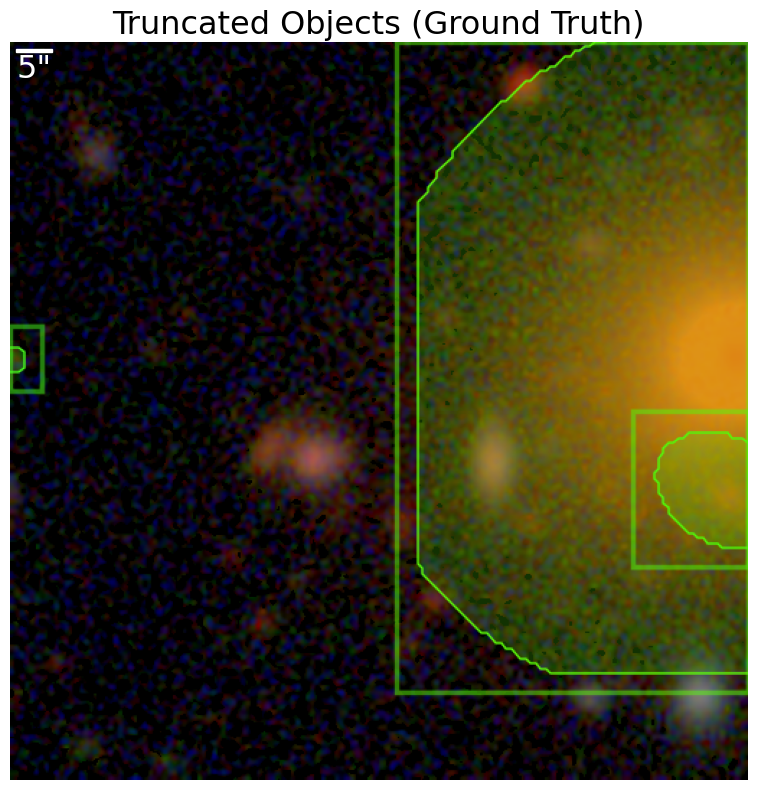

In [12]:
truncated_random_img = visualize_truncated_objects(evaluator, random_img)

## Truncation Stats for All Imgs in Test Set

In [13]:
stats = analyze_truncation(test_data)

In [17]:
print(f"Total objects analyzed: {stats['total_objects']}")
print(f"Total truncated objects: {stats['total_truncated']}")
print(f"Truncation percentage: {stats['truncation_percentage']:.2f}%")
print("\nTruncation by edge:")
print(f"Left: {stats['left']}")
print(f"Right: {stats['right']}")
print(f"Top: {stats['top']}")
print(f"Bottom: {stats['bottom']}")
print(f"\nTotal Images: {len(test_data)}")
print(f"Images containing truncated objects: {stats['images_with_truncation']}")

Total objects analyzed: 19404
Total truncated objects: 1410
Truncation percentage: 7.27%

Truncation by edge:
Left: 465
Right: 274
Top: 411
Bottom: 260

Total Images: 658
Images containing truncated objects: 587


In [14]:
# with segmentation mask filtering
stats = analyze_truncation(test_data)

In [19]:
print(f"Total objects analyzed: {stats['total_objects']}")
print(f"Total truncated objects: {stats['total_truncated']}")
print(f"Truncation percentage: {stats['truncation_percentage']:.2f}%")
print("\nTruncation by edge:")
print(f"Left: {stats['left']}")
print(f"Right: {stats['right']}")
print(f"Top: {stats['top']}")
print(f"Bottom: {stats['bottom']}")
print(f"\nTotal Images: {len(test_data)}")
print(f"Images containing truncated objects: {stats['images_with_truncation']}")

Total objects analyzed: 19404
Total truncated objects: 1410
Truncation percentage: 7.27%

Truncation by edge:
Left: 465
Right: 274
Top: 411
Bottom: 260

Total Images: 658
Images containing truncated objects: 587


Total objects: 36
Truncated objects: 3
Filename: ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy


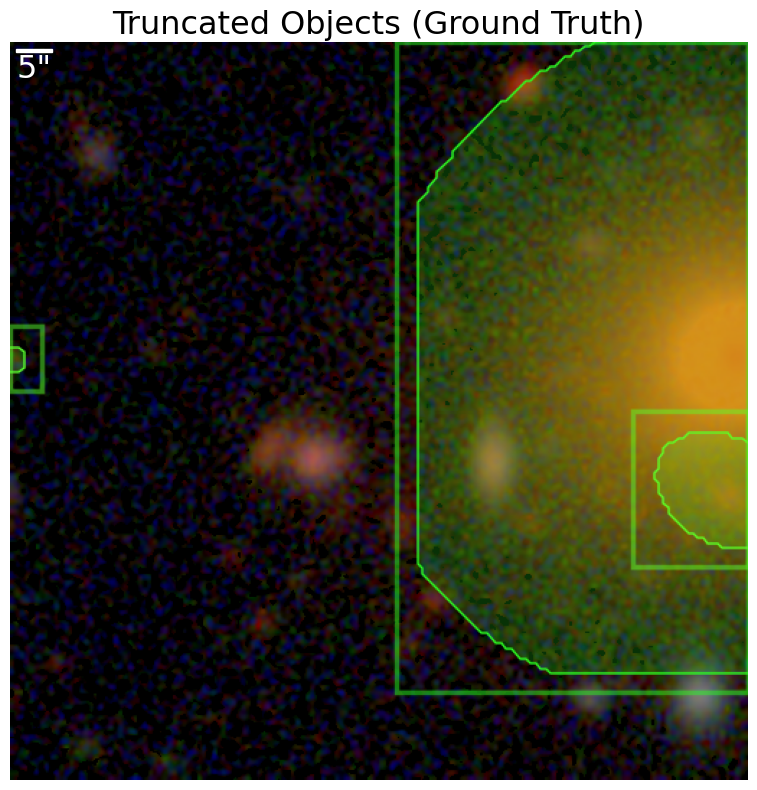

In [15]:
rfilename = stats['truncated_by_image'][0]['file_name'] # gives us filename of img that has truncated objs
rimg_2 = [d for d in test_data if d['file_name'] == rfilename][0] # we grab corresponding img
truncated_random_img = visualize_truncated_objects(evaluator, rimg_2) # plot the img with just truncated objs
# 0 is the one with the large object cutout
# 200 is a good one './lsst_data/truthc-ups/dc2_53.25_-41.8/full_c85_53.25_-41.8.npy'
# 225 Filename: ./lsst_data/truthc-ups/dc2_53.75_-38.9/full_c171_53.75_-38.9.npy
# 226 ./lsst_data/truthc-ups/dc2_50.93_-42.0/full_c301_50.93_-42.0.npy
# get obj properties (size vs mag) of truncated objs

## Creating Cutouts with Truncated Object Centered

In [16]:
trunc_img = stats['truncated_by_image'][0]
trunc_img
# for i in trunc_img:
#     if i['file_name'] == './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy':
#         print(i['file_name'])

{'imid': 108,
 'obj_id': [1, 9, 19],
 'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3.npy',
 'subpatch': 'dc2_51.37_-38.3',
 'trunc_obs_in_image': 3}

### New Cutout's Anns

In [22]:
def create_centered_cutouts(test_data, truncation_stats, cutout_size=512, single=False):
    """
    Returns:
        new img dicts for centered cutouts
    """
    new_cutouts = []
    
    for entry in truncation_stats['truncated_by_image']:
        print(entry['obj_id'])
        filename = entry['file_name']
        obj_id = entry['obj_id']
        orig_img = next(img for img in test_data if img['file_name'] == filename)
#         print(orig_img)
        obj_ann = next(ann for ann in orig_img['annotations'] if ann['obj_id'] == obj_id)
        
        # obj center from bbox
        x, y, w, h = obj_ann['bbox']
#         print(x, y, w, h)
        center_x = x + w/2
        center_y = y + h/2
#         print(center_x, center_y)
        
        # new cutout boundaries centered on obj
        half_size = cutout_size/2
        new_x0 = int(np.rint(max(0, center_x - half_size)))
        new_y0 = int(np.rint(max(0, center_y - half_size)))
        
        # new dict w/ adjusted coords
        new_cutout = orig_img.copy()
        new_cutout['file_name'] = filename.replace('.npy', f'_centered_{obj_id}.npy')
        
        # change all annotation coords relative to new cutout origin
        new_anns = []
        for ann in orig_img['annotations']:
            ann_x, ann_y, ann_w, ann_h = ann['bbox']
            
            new_x = ann_x - new_x0
            new_y = ann_y - new_y0
            # track objs that are in the corners of each subpatch cutout
            if (0 <= new_x and new_x + ann_w <= cutout_size and 
                0 <= new_y and new_y + ann_h <= cutout_size):
                
                new_ann = ann.copy()
                new_ann['bbox'] = [new_x, new_y, ann_w, ann_h]
                
                new_segmentation = []
                for segment in ann['segmentation']:
                    points = np.array(segment).reshape(-1, 2)
                    points[:, 0] -= new_x0  # Adjust x coordinates
                    points[:, 1] -= new_y0  # Adjust y coordinates
                    new_segmentation.append(points.flatten().tolist())
                    
                new_ann['segmentation'] = new_segmentation
                new_anns.append(new_ann)
        
        new_cutout['annotations'] = new_anns
        new_cutouts.append(new_cutout)
        if single == True:
            break
        
    return new_cutouts

# run inference on both sets and then filter out duplicates based on confidence threshold
# run the rest of the metrics with the filtered catalog

OG cond:
```python
if (0 <= new_x + ann_w and new_x < cutout_size and 
    0 <= new_y + ann_h and new_y < cutout_size):
```

New cond:
```python
if (0 <= new_x and new_x + ann_w <= cutout_size and 
    0 <= new_y and new_y + ann_h <= cutout_size):
```

| Scenario | Original Condition | Suggested Condition |
|----------|--------------------|--------------------|
| Object partially outside left/top | Included | Excluded |
| Object partially outside right/bottom | Included | Excluded |
| Object fully inside | Included | Included |
| Object larger than cutout | Potentially included | Always excluded |

This is why the OG cond was including objs that are partially visible in the cutout, resulting in negative values in segmentation arrs (we don't want to capture all visible objects, esp if they're cut off). The new cond will only include objs that are fully contained within the cutout, ensuring complete annotations for each included object.

In [61]:
a = create_centered_cutouts(test_data, stats, single=True)

39


In [60]:
# reject objs outside this new cutout since they alr exist in new cutout
# checking if any neg segm values exist
np.sum([1 if value < 0 else 0 for ann in a[0]['annotations'] for seg in ann['segmentation'] for value in seg]) 

0

In [62]:
a[0]

{'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3_centered_39.npy',
 'image_id': 108,
 'height': 512,
 'width': 512,
 'subpatch': 'dc2_51.37_-38.3',
 'annotations': [{'obj_id': 0,
   'bbox': [1.7600021362304688,
    425.0816345214844,
    37.546669006347656,
    38.31292724609375],
   'area': 121,
   'bbox_mode': 1,
   'segmentation': [[20,
     440,
     17,
     444,
     17,
     447,
     20,
     451,
     23,
     451,
     27,
     447,
     27,
     444,
     23,
     440]],
   'category_id': 1,
   'redshift': 0.0,
   'mag_r': 26.7892990112},
  {'obj_id': 2,
   'bbox': [35.89332580566406,
    355.4217834472656,
    44.37333679199219,
    45.278900146484375],
   'area': 169,
   'bbox_mode': 1,
   'segmentation': [[54,
     371,
     51,
     374,
     51,
     385,
     54,
     388,
     64,
     388,
     68,
     385,
     68,
     374,
     64,
     371]],
   'category_id': 0,
   'redshift': 0.1757053149,
   'mag_r': 25.3119940175},
  {'obj_id': 3,


### Grabbing Corresponding Image Data

51.4544720466 -38.3375330377
51.454558899 -38.3360072859
51.4648041434 -38.3375651335


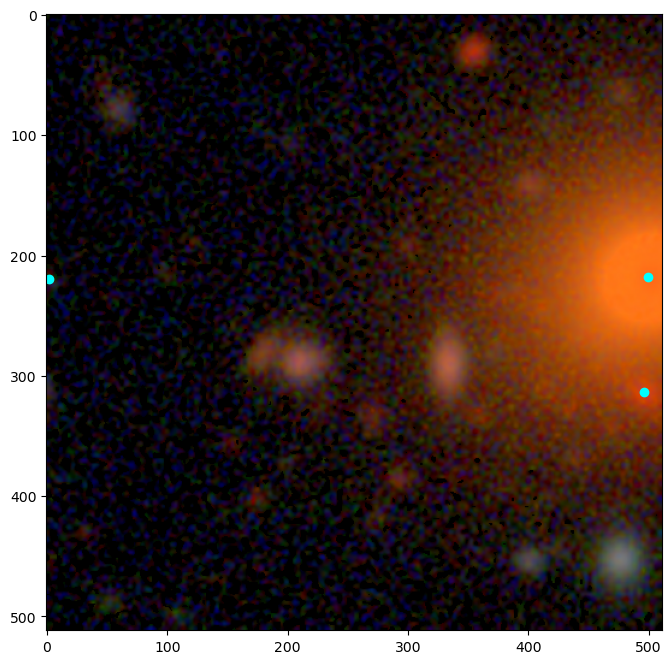

In [17]:
import matplotlib.colors as colors
img = np.load(trunc_img['file_name'])
img = make_lupton_rgb(img[2,:,:], img[1,:,:], img[0,:,:], minimum=0, stretch=0.5, Q=10)
truth_info = pd.read_json(f'lsst_data/truthc-ups/dc2{trunc_img["subpatch"][3:]}/dc2{trunc_img["subpatch"][3:]}_info.json', orient='records')
objs = pd.read_json(truth_info[truth_info['file_name'] == trunc_img['file_name']]['obj_catalog'].values[0])
plt.figure(figsize=(10, 8))
plt.imshow(img)
# plt.scatter(objs['new_x'], objs['new_y'])
for i in trunc_img['obj_id']:
    print(objs['ra'].iloc[i], objs['dec'].iloc[i])
    plt.scatter(objs['new_x'].iloc[i], objs['new_y'].iloc[i], c='cyan')

In [24]:
SkyCoord(ra=objs['ra'].iloc[trunc_img['obj_id']]*u.degree, 
        dec=objs['dec'].iloc[trunc_img['obj_id']]*u.degree)

<SkyCoord (ICRS): (ra, dec) in deg
    [(51.45447205, -38.33753304), (51.4545589 , -38.33600729),
     (51.46480414, -38.33756513)]>

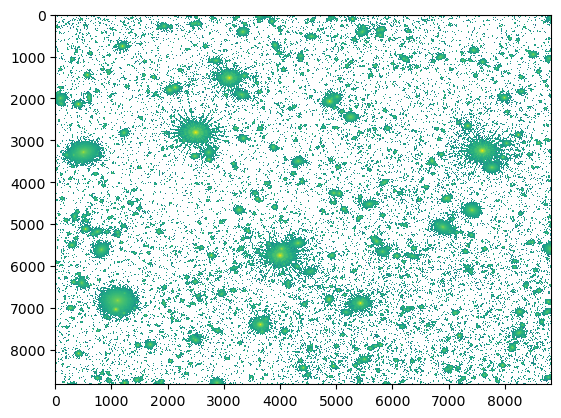

In [45]:
# full_img_data = np.stack((f184_img[1].data, h158_img[1].data, y106_img[1].data, j129_img[1].data))
img_data =  np.load(f'roman_data/truth/dc2{trunc_img["subpatch"][3:]}/full{trunc_img["subpatch"][3:]}.npy')[0, :, :]
# wcs of full image isn't saved so we need to grab it directly from the file
w = WCS(fits.open(f'roman_data/original_fits/dc2_F184{trunc_img["subpatch"][3:]}.fits')[1].header)
plt.imshow(img_data, norm=colors.LogNorm(), aspect='auto')

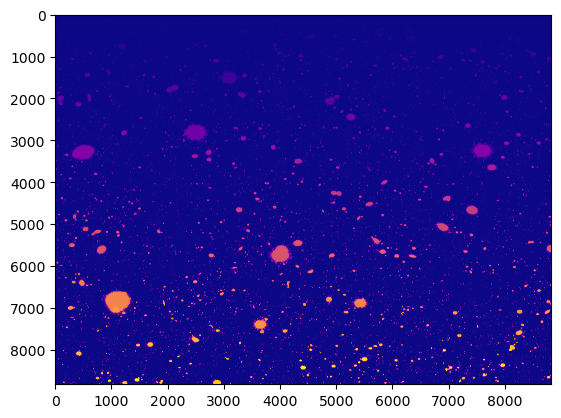

In [46]:
seg_mask = fits.open(f'roman_data/segmentation_fits/dc2_seg{trunc_img["subpatch"][3:]}.fits.gz')
plt.imshow(seg_mask[0].data, cmap='plasma', aspect='auto')

In [48]:
cutout_size = 512
x_steps = np.arange(0, seg_mask[0].data.shape[1], cutout_size)
y_steps = np.arange(0, seg_mask[0].data.shape[0], cutout_size)
# Finding the actual cutouts
seg_cutouts = []
for y in y_steps:
    for x in x_steps:
        # partial mode and set fill_value to zero since we will ignore it anyway
        seg_cutout = Cutout2D(seg_mask[0].data, position=(x + cutout_size/2, y + cutout_size/2), size=cutout_size, wcs=w, mode='partial', fill_value=0)
        seg_cutouts.append(seg_cutout) # seg_cutout.wcs() is what we shld preserve
#         raw_cutout_f184 = Cutout2D(full_img_data[0], position=(x + cutout_size/2, y + cutout_size/2), size=cutout_size, wcs=w, mode='partial', fill_value=0)
#         raw_cutout_h158 = Cutout2D(full_img_data[1], position=(x + cutout_size/2, y + cutout_size/2), size=cutout_size, wcs=w, mode='partial', fill_value=0)
#         raw_cutout_y106 = Cutout2D(full_img_data[2], position=(x + cutout_size/2, y + cutout_size/2), size=cutout_size, wcs=w, mode='partial', fill_value=0)
#         raw_cutout_j129 = Cutout2D(full_img_data[3], position=(x + cutout_size/2, y + cutout_size/2), size=cutout_size, wcs=w, mode='partial', fill_value=0)

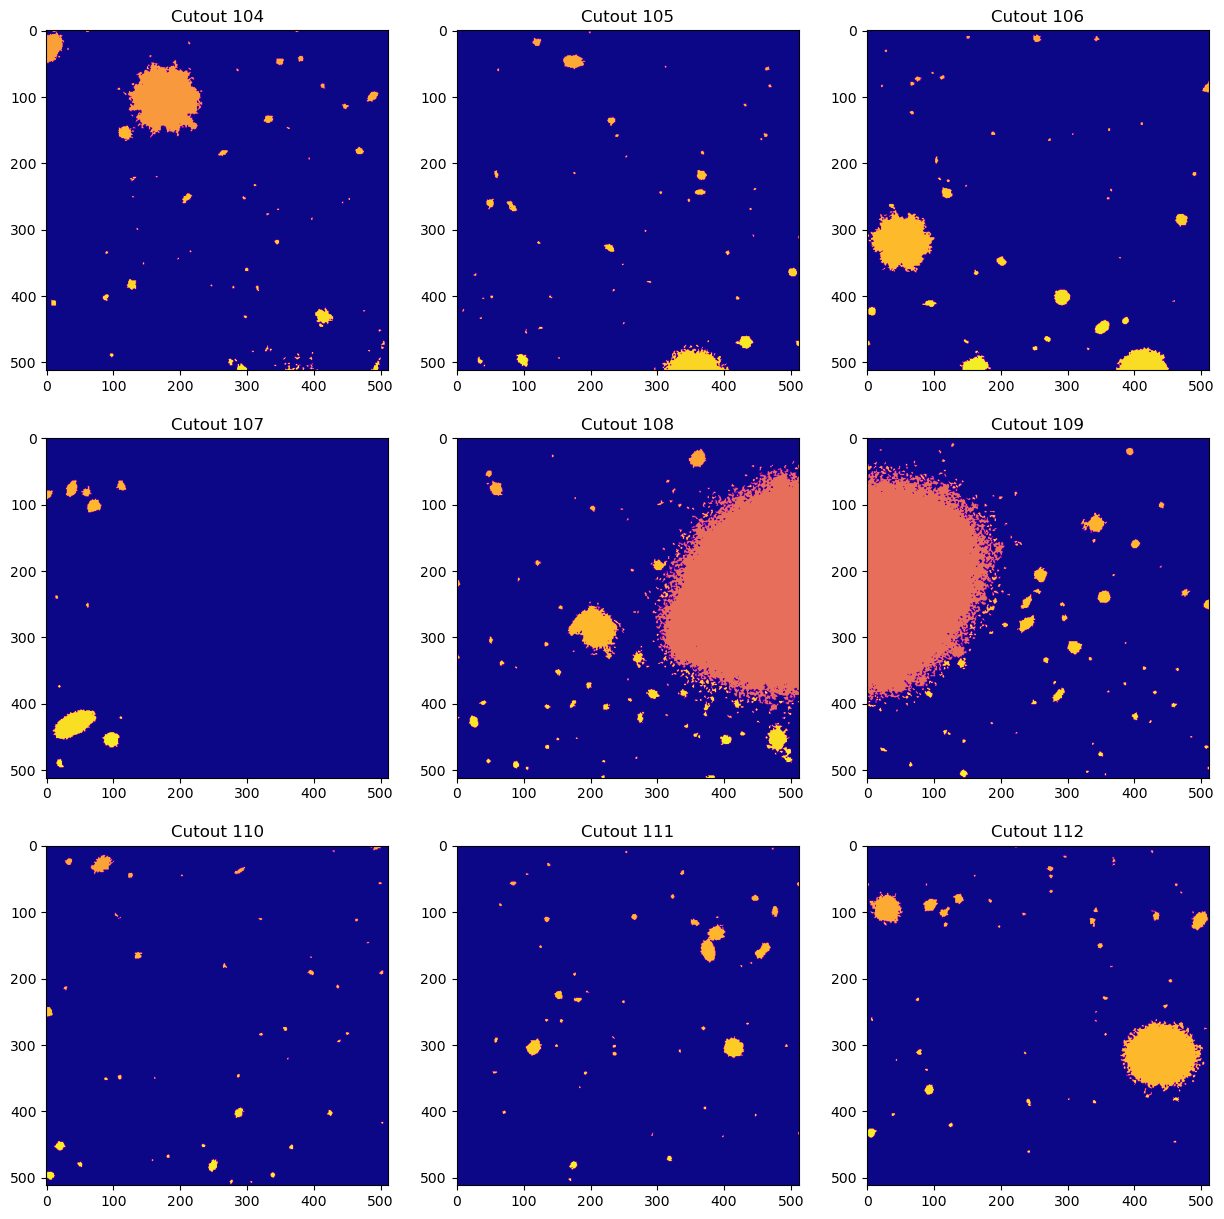

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
demo_cutouts_mid = seg_cutouts[104:113]
for i, seg_cutout in enumerate(demo_cutouts_mid):
    axes[i].imshow(seg_cutout.data, cmap='plasma', aspect='auto')
    axes[i].set_title(f'Cutout {104+i}')

In [51]:
def create_centered_image_cutouts(test_data, truncation_stats, cutout_size=512, single=False):
    """
    Creates new image cutouts centered on truncated objects, along with their annotations
    
    Args:
        test_data: img dicts with anns
        truncation_stats: dict abt info on truncated objs
        cutout_size: size of new cutout
    
    Returns:
        dictionaries containing new cutout data and annotations
    """
    new_cutouts = []
#     new_img = []
    
    for entry in truncation_stats['truncated_by_image']:
        filename = entry['file_name']
        obj_ids = entry['obj_id']
        subpatch = entry['subpatch']
        
        # load full image data and WCS
        full_img_data = np.load(f'roman_data/truth/dc2{subpatch[3:]}/full{subpatch[3:]}.npy')
        seg_mask = fits.open(f'roman_data/segmentation_fits/dc2_seg{subpatch[3:]}.fits.gz')
#         f184_hdu = fits.open(f'roman_data/original_fits/dc2_F184{subpatch[3:]}.fits')[1]
#         w = WCS(f184_hdu.header)
        w = WCS(fits.open(f'roman_data/original_fits/dc2_F184{subpatch[3:]}.fits')[1].header)
#         print("Type of w:", type(w))
        print("WCS info:", w)
        
        # get object's RA and DEC from truth info
        truth_info = pd.read_json(f'lsst_data/truthc-ups/dc2{subpatch[3:]}/dc2{subpatch[3:]}_info.json', orient='records')
        obj_cat = pd.read_json(truth_info[truth_info['file_name'] == filename]['obj_catalog'].values[0])
#        get original img dict
        orig_img = next(img for img in test_data if img['file_name'] == filename)

        new_img_data = []
        new_segm_data = []

        for obj_id in obj_ids:
            if obj_id == 19: 
#                     continue
            # coordinates for the object
                coords = SkyCoord(ra=obj_cat['ra'].iloc[obj_id]*u.degree, 
                                 dec=obj_cat['dec'].iloc[obj_id]*u.degree)
                print("In for loop: \n", w)
                x, y = w.world_to_pixel(coords)

    #             for channel in range(full_img_data.shape[0]):
                cutout = Cutout2D(
    #                 full_img_data[channel], 
                    full_img_data[0, :, :],
                    position=(x, y),
                    size=cutout_size,
                    wcs=w,
                    mode='partial',
                    fill_value=0
                )
                new_img_data.append(cutout.data)
    #             new_img_data = np.stack(new_img_data)
                # Save new image data
    #             new_filename = filename.replace('.npy', f'_centered_{obj_id}.npy')
                # Save new image data
                # create segmentation cutout
                seg_cutout = Cutout2D(
                    seg_mask[0].data,
                    position=(x, y),
                    size=cutout_size,
                    wcs=w,
                    mode='partial',
                    fill_value=0
                )
                new_segm_data.append(seg_cutout.data)

                new_filename = filename.replace('.npy', f'_centered_{obj_id}.npy')
    #             np.save(new_filename, new_img_data)
                # new image dict with updated annotations
                trunc_obj_ann = [ann for ann in orig_img['annotations'] if ann['obj_id'] == obj_id][0]
                new_cutout = {}
                new_cutout['file_name'] = new_filename
                new_cutout['image_id'] = orig_img['image_id'] 
                new_cutout['height'] = cutout_size
                new_cutout['width'] = cutout_size
                new_cutout['subpatch'] = subpatch
                # anns for objects in cutout
                anns = []
                for s in np.unique(seg_cutout.data):
                    if s == 0:  
                        continue

                    mask = np.zeros(seg_cutout.data.shape)
                    s0i = np.where(seg_cutout.data == s)
                    mask[s0i] = 1

                    x0 = s0i[1].min()
                    x1 = s0i[1].max()
                    y0 = s0i[0].min()
                    y1 = s0i[0].max()
                    h = int(y1-y0)
                    w = int(x1-x0)

                    contours, _ = cv2.findContours(
                        mask.astype(np.uint8), 
                        cv2.RETR_TREE, 
                        cv2.CHAIN_APPROX_SIMPLE
                    )

                    segmentation = []
                    for contour in contours:
                        contour = contour.flatten()
                        if len(contour) > 4:
                            segmentation.append(contour.tolist())

                    if len(segmentation) > 0:
                        obj = {
                            "bbox": [int(x0), int(y0), w, h],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "area": w * h,
                            "segmentation": segmentation,
                            "category_id": trunc_obj_ann['category_id'],  # same category
                            "obj_id": int(s),
                            "redshift": trunc_obj_ann["redshift"],
                            "mag_r": trunc_obj_ann["mag_r"],
                            "orig_obj_id": obj_id
                        }
                        anns.append(obj)

                new_cutout['annotations'] = anns
                new_cutouts.append(new_cutout)
                if single:
                    return new_cutouts, new_img_data, new_segm_data
        
    return new_cutouts, new_img_data, new_segm_data

In [52]:
new_cutouts, new_img_data, new_segm_data = create_centered_image_cutouts(test_data, stats, single=True)

WCS info: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 51.37494079521789  -38.31967881944444  
CRPIX : 4413.0  4413.0  
CD1_1 CD1_2  : -1.5972222222222e-05  -3.0376401359668e-22  
CD2_1 CD2_2  : -4.0725055943496e-22  1.59722222222222e-05  
NAXIS : 8825  8825
In for loop: 
 WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 51.37494079521789  -38.31967881944444  
CRPIX : 4413.0  4413.0  
CD1_1 CD1_2  : -1.5972222222222e-05  -3.0376401359668e-22  
CD2_1 CD2_2  : -4.0725055943496e-22  1.59722222222222e-05  
NAXIS : 8825  8825


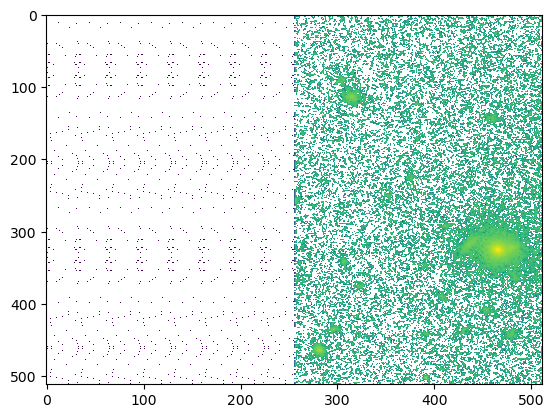

In [53]:
plt.imshow(new_img_data[0], norm=colors.LogNorm(), aspect='auto')

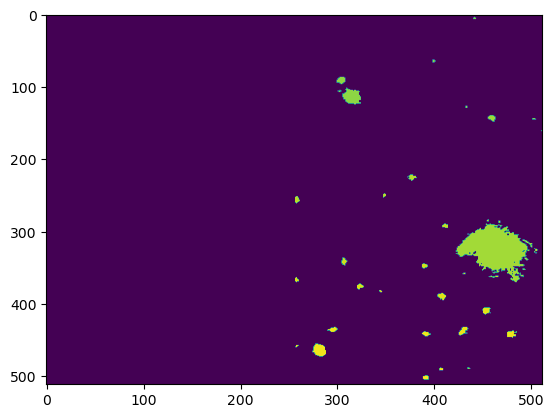

In [54]:
plt.imshow(new_segm_data[0], aspect='auto')

In [190]:
for segm in new_segm_data:
    print(np.unique(segm[np.where(segm != 0)]))
#     if segm != 0:
#     print(segm)

[5296 6643 6646 6671 6676 6685 6693 6703 6706 6712 6724 6729 6758 6798
 6813 6831 6842 6854 6855 6864 6868 6869 6870 6882 6883 6884 6888 6890
 6893 6896 6897 6898 6904 6905 6912 6919 6932 6933 6938 6939 6942 6944
 6950 6957 6958 6971 6972 6973 6976 6979 6985 6986 6993 6998 7000 7003
 7021 7024 7029 7030 7031 7033 7036 7045 7046 7047 7049 7052 7054 7057
 7065 7066 7070 7072 7077 7081 7083 7094 7096 7097 7107 7114 7134 7135
 7139 7163 7172 7177 7178 7194 7199 7201 7203 7206 7209 7214 7224 7232
 7234 7237 7239 7259 7261 7266 7272 7273 7280 7282 7286 7295 7298 7329
 7354 7358 7371 7373 7374 7376 7377 7393 7404 7405 7407 7414 7419 7442
 7443 7444 7446 7447 7449 7453 7461 7467 7468 7472 7474 7475 7480 7484
 7493 7499 7507 7514 7526 7550 7552 7565 7569 7576 7577 7587 7588 7594
 7596 7614 7625 7647 7660 7673 7675 7688 7706 7707 7723 7724 7737 7742
 7747 7757 7760 7774 7794 7811 7813 7829 7832 7838 7852 7853 7854 7855
 7864 7865 7867 7872 7877 7878 7887 7892 7894 7895 7902 7906 7907 7916
 7917 

In [26]:
new_cutouts[0]

{'file_name': './lsst_data/truthc-ups/dc2_51.37_-38.3/full_c108_51.37_-38.3_centered_1.npy',
 'image_id': 108,
 'height': 512,
 'width': 512,
 'subpatch': 'dc2_51.37_-38.3',
 'annotations': [{'bbox': [46, 80, 420, 365],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'area': 153300,
   'segmentation': [[233,
     80,
     232,
     81,
     230,
     81,
     229,
     82,
     231,
     82,
     232,
     81,
     233,
     82,
     233,
     88,
     234,
     88,
     235,
     89,
     233,
     91,
     230,
     91,
     229,
     90,
     230,
     89,
     231,
     89,
     231,
     88,
     229,
     88,
     229,
     89,
     227,
     91,
     226,
     90,
     226,
     87,
     228,
     85,
     227,
     85,
     226,
     84,
     225,
     84,
     223,
     82,
     223,
     84,
     222,
     85,
     219,
     85,
     217,
     87,
     215,
     85,
     214,
     85,
     214,
     88,
     213,
     89,
     215,
     91,
     215,
     92,
     214,
     93,
   

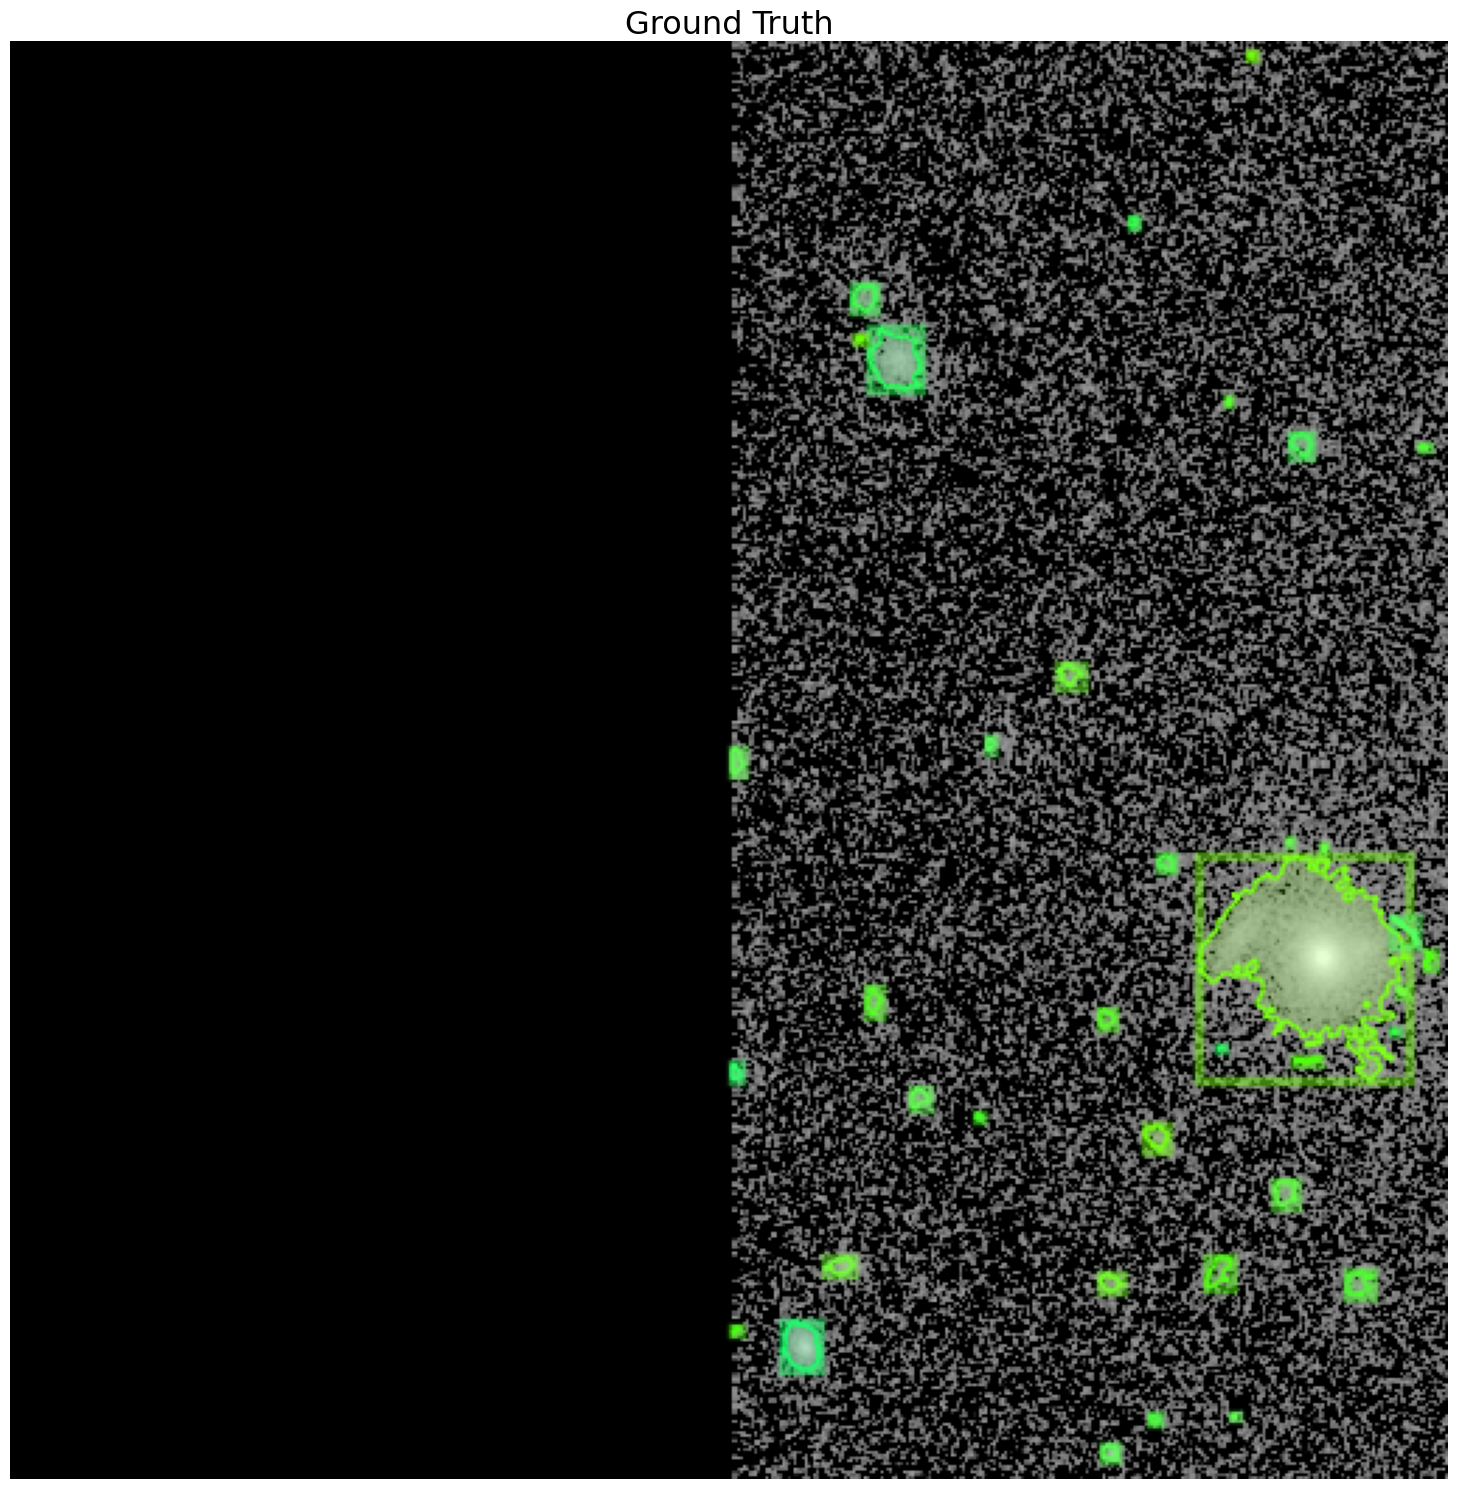

In [56]:
fontprops = fm.FontProperties(size=23)

# new_img_data
img = make_lupton_rgb(new_img_data[0], new_img_data[0], new_img_data[0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.axis("off")

v_gt = Visualizer(
    img.copy(),
    metadata=evaluator.registered_test_data,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
)
axes.set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(new_cutouts[0], lf=False,alpha=0.2)
axes.imshow(ground_truth.get_image())
# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# # save if needed
# output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
# plt.savefig(output_path)
# print(f"Plots saved to {output_path}")
# filter out test set if obj extends beyond cutout
# center of obj outside cutout -> done by doing cut by filtering by bounds
# center is within cutout but bbdox is large enough such that it goes into a diff cutout -> check if bbox brushes up against the edge of the cutout
# figure out how many objs are truncated by analyzing the bbox coords and make a new cutout for that obj and run inference on the new test set

In [ ]:
rfilename = stats['truncated_by_image'][225]['file_name'] # gives us filename of img that has truncated objs
rimg_2 = [d for d in test_data if d['file_name'] == rfilename][0] # we grab corresponding img
truncated_random_img = visualize_truncated_objects(evaluator, rimg_2) # plot the img with just truncated objs

# Detection Completeness

In [ ]:
def detection_completeness(dd_det_cat, test_truth_cat):
    # return 0 if truth catalog is empty
    if len(test_truth_cat) == 0:
        return 0.0
    ras = dd_det_cat.ra.values
    decs = dd_det_cat.dec.values
    coord = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    
    ras_2 = test_truth_cat.ra_truth_merged.values
    decs_2 = test_truth_cat.dec_truth_merged.values
    allcatalog = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)
   
    idx, d2d, d3d = coord.match_to_catalog_sky(allcatalog)
    minds = np.where(d2d.to(u.arcsec).value<=0.5)
    comp = len(minds[0])/len(test_truth_cat)
    return comp

In [ ]:
# just LSST images was 77%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')

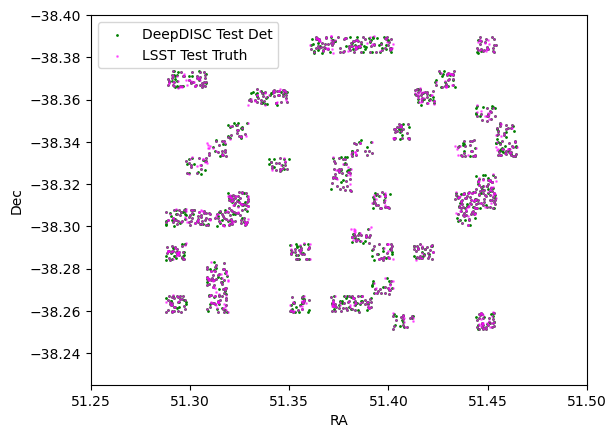

In [ ]:
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['green'], label='DeepDISC Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

In [ ]:
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" , detection_completeness(dd_det_cat_df, lsst_test_truth), 
# (0.7330014769432744, 'DeepDISC Completeness', 0.779607242492205)

(0.7330014769432744, 'DeepDISC Completeness', 0.779607242492205)

In [ ]:
mags = np.arange(min(lsst_test_truth['mag_i'].values), max(lsst_test_truth['mag_i'].values),0.5)
dcs = []
for i in range(1,len(mags)):
    dc = detection_completeness(dd_det_cat_df,lsst_test_truth.iloc[np.where(np.digitize(lsst_test_truth.mag_i.values, bins=mags)==i)])
    dcs.append(dc)

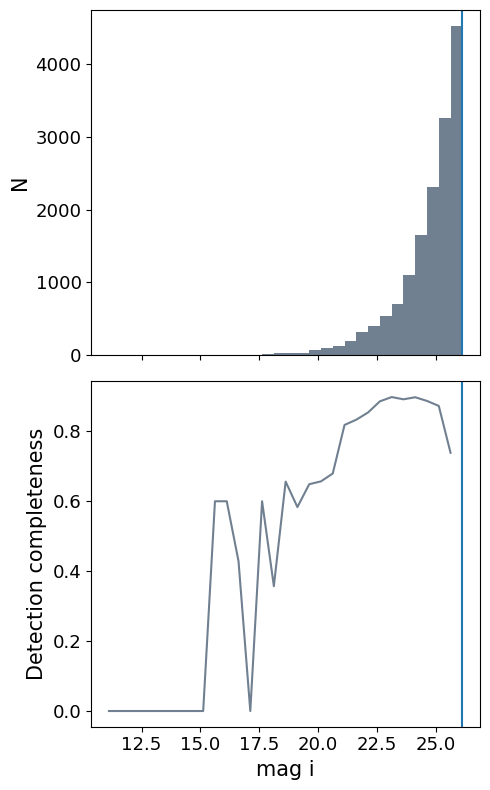

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].hist(lsst_test_truth.mag_i.values, bins=mags, color='slategrey')
ax[1].plot(mags[:-1], dcs, color='slategrey')
ax[1].set_xlabel('mag i',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[1].set_ylabel('Detection completeness',fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax[1].axvline(max(mags))
ax[0].axvline(max(mags))

In [ ]:
# combined images was 83%
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')

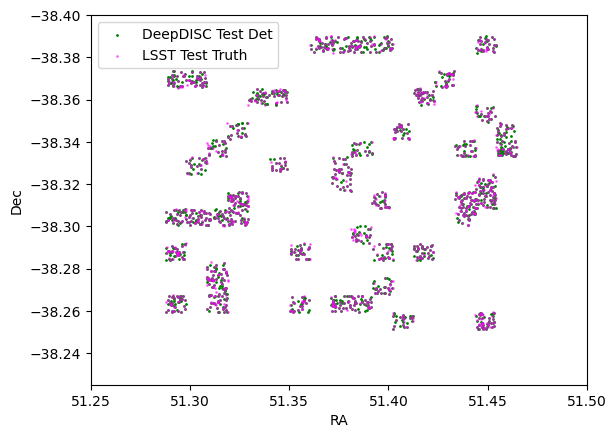

In [ ]:
plt.scatter(dd_det_cat_df['ra'], dd_det_cat_df['dec'], s=1, c=['green'], label='DeepDISC Test Det')
plt.scatter(lsst_test_truth['ra_truth_merged'], lsst_test_truth['dec_truth_merged'], s=1, c=['magenta'], label='LSST Test Truth', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(51.25,51.50)
plt.ylim(-38.225, -38.40)
plt.legend(loc='best')

In [ ]:
detection_completeness(lsst_test_det, lsst_test_truth), "DeepDISC Completeness" ,detection_completeness(dd_det_cat_df, lsst_test_truth), 
# (0.733700092597636, 'DeepDISC Completeness', 0.8307642028432921)

(0.733700092597636, 'DeepDISC Completeness', 0.8307642028432921)

In [ ]:
mags = np.arange(min(lsst_test_truth['mag_i'].values), max(lsst_test_truth['mag_i'].values),0.5)
dcs = []
for i in range(1,len(mags)):
    dc = detection_completeness(dd_det_cat_df,lsst_test_truth.iloc[np.where(np.digitize(lsst_test_truth.mag_i.values, bins=mags)==i)])
    dcs.append(dc)

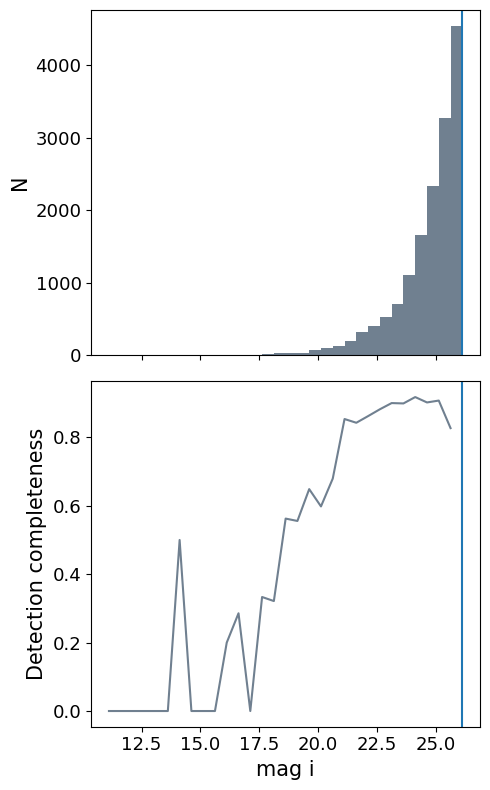

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].hist(lsst_test_truth.mag_i.values, bins=mags, color='slategrey')
ax[1].plot(mags[:-1], dcs, color='slategrey')
ax[1].set_xlabel('mag i',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[1].set_ylabel('Detection completeness',fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax[1].axvline(max(mags))
ax[0].axvline(max(mags))

# 1-1 Matching of Det to Truth

In [4]:
# lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_truth_cat.json')
# lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotations/lsst_test_det_cat.json')
# dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run2_sm/dd_test_det.json')
lsst_test_truth = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth_cat.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det_cat.json')
dd_det_cat_df = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det.json')

In [5]:
# 2 less than magnitude based on cutoff
lsst_test_truth['mag_i'].describe()

count    18359.000000
mean        24.930973
std          1.450045
min         11.116846
25%         24.395074
50%         25.368793
75%         25.933767
max         26.439188
Name: mag_i, dtype: float64

In [6]:
def match_with_truth(det_cat, truth_cat, max_sep=0.5*u.arcsec):
    """
    Match detection catalog with truth catalog with search around sky
    Only keep 1-to-1 matches within max_sep
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()

    det_coords = SkyCoord(ra=det_cat['ra']*u.deg, 
                         dec=det_cat['dec']*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra_truth_merged']*u.deg, 
                           dec=truth_cat['dec_truth_merged']*u.deg)
    
    idx_det, d2d, _ = det_coords.match_to_catalog_sky(truth_coords)
    good_sep = d2d <= max_sep
    # count how many truth objs match to each det and keep 1-to-1 matches
    unique_truth, truth_counts = np.unique(idx_det[good_sep], return_counts=True)
    good_truth = unique_truth[truth_counts == 1]
    
    final_mask = good_sep & np.isin(idx_det, good_truth)
    matched_det_indices = np.where(final_mask)[0]
    matched_truth_indices = idx_det[final_mask]
    
    matched_det = det_cat.iloc[matched_det_indices].copy()
    matched_truth = truth_cat.iloc[matched_truth_indices].copy()
    
    print(f"Found {len(matched_det)} matched pairs")
    
#     print(final_matches)
    return matched_det, matched_truth

In [7]:
len(lsst_test_det), len(lsst_test_truth), len(dd_det_cat_df)

(13827, 18359, 22263)

In [8]:
lsst_test_matched_det, lsst_test_matched_truth = match_with_truth(lsst_test_det, lsst_test_truth)

Found 13461 matched pairs


In [9]:
# lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotations/lsst_test_det11_cat.json', orient='records')
# lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotations/lsst_test_truth11_cat.json', orient='records')

lsst_test_matched_det.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json', orient='records')
lsst_test_matched_truth.to_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_truth11_cat.json', orient='records')

In [10]:
dd_matched_det, dd_matched_truth = match_with_truth(dd_det_cat_df, lsst_test_truth)

Found 15026 matched pairs


In [11]:
dd_matched_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json', orient='records')
dd_matched_truth = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

# Obj Properties

In [12]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
def generate_obj_plots(truth_cat):
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    # size vs mag scatter
    ax1 = fig.add_subplot(gs[0, :2])
    scatter = ax1.scatter(truth_cat['mag_i'], 
                         truth_cat['size_true'],
                         c=truth_cat['redshift_truth_merged'],
                         alpha=0.5, cmap='viridis')
    ax1.set_xlabel('mag i')
    ax1.set_ylabel('True Size (arcsec)')
    ax1.set_title('Size vs Mag colored by Redshift')
    plt.colorbar(scatter, ax=ax1, label='Redshift') # where blue/purple means lower redshifts (closer objs) and yellow/green means higher redshifts (more distant objs)

    # mag hist
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist(truth_cat['mag_i'], bins=50)
    ax2.set_xlabel('mag i')
    ax2.set_ylabel('Count')
    ax2.set_title('Mag Distribution')

    # size hist
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(truth_cat['size_true'], bins=50)
    ax3.set_xlabel('Size (arcsec)')
    ax3.set_ylabel('Count')
    ax3.set_title('Size Distribution')

    # ellip distribution
    ax4 = fig.add_subplot(gs[1, 1])
    e1 = truth_cat['ellipticity_1_true']
    e2 = truth_cat['ellipticity_2_true']
    ax4.scatter(e1, e2, alpha=0.5, s=1)
    ax4.set_xlabel('e1')
    ax4.set_ylabel('e2')
    ax4.set_title('Ellipticity Distribution')
    ax4.set_aspect('equal')

    # redshift histogram
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.hist(truth_cat['redshift_truth_merged'], bins=50)
    ax5.set_xlabel('Redshift')
    ax5.set_ylabel('Count')
    ax5.set_title('Redshift Distribution')

    plt.tight_layout()
    
def generate_box_plots(truth_cat):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    # size by type
    sns.boxplot(data=truth_cat, x='truth_type', y='size_true', ax=axes[0,0])
    axes[0,0].set_title('Size Distribution by Object Type')
    axes[0,0].set_xlabel('Object Type (1=galaxy, 2=star)')

    sns.boxplot(data=truth_cat, x='truth_type', y='mag_i', ax=axes[0,1])
    axes[0,1].set_title('Mag i Distribution by Object Type')
    axes[0,1].set_xlabel('Object Type (1=galaxy, 2=star)')

    e_tot = np.sqrt(truth_cat['ellipticity_1_true']**2 + 
                    truth_cat['ellipticity_2_true']**2)
    truth_cat['total_ellipticity'] = e_tot
    sns.boxplot(data=truth_cat, x='truth_type', y='total_ellipticity', ax=axes[1,0])
    axes[1,0].set_title('Total Ellipticity by Object Type')
    axes[1,0].set_xlabel('Object Type (1=galaxy, 2=star)')

    sns.boxplot(data=truth_cat, x='truth_type', y='redshift_truth_merged', ax=axes[1,1])
    axes[1,1].set_title('Redshift Distribution by Object Type')
    axes[1,1].set_xlabel('Object Type (1=galaxy, 2=star)')

    plt.tight_layout()

## LSST Test Truth Objects

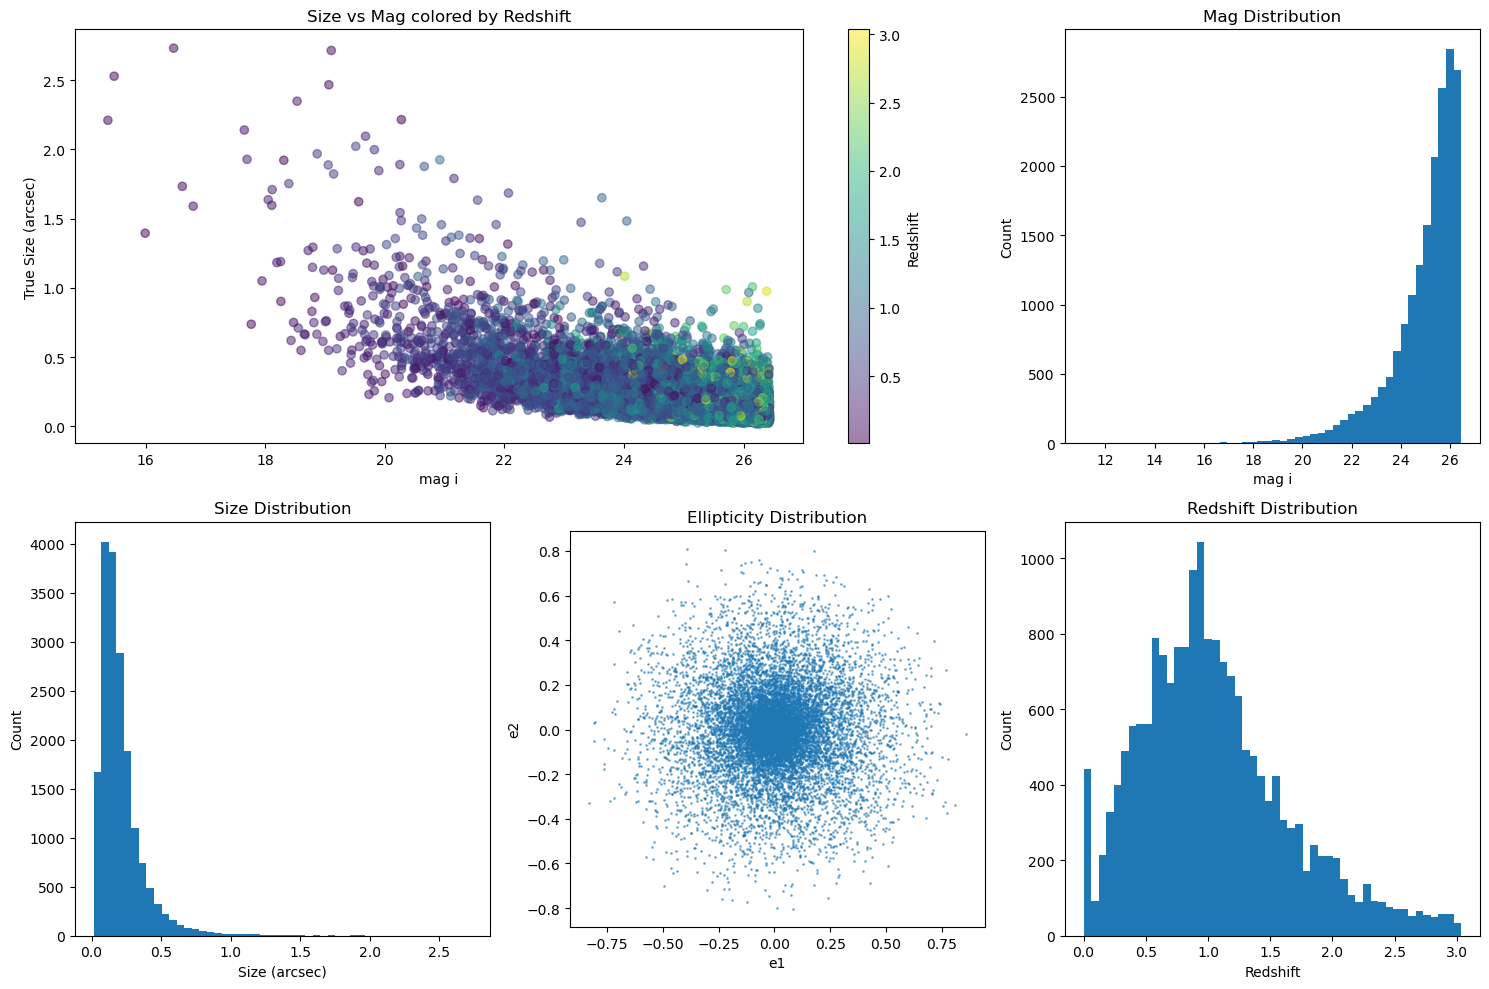

In [69]:
generate_obj_plots(lsst_test_truth)

## Matched LSST Det and LSST Truth Objs

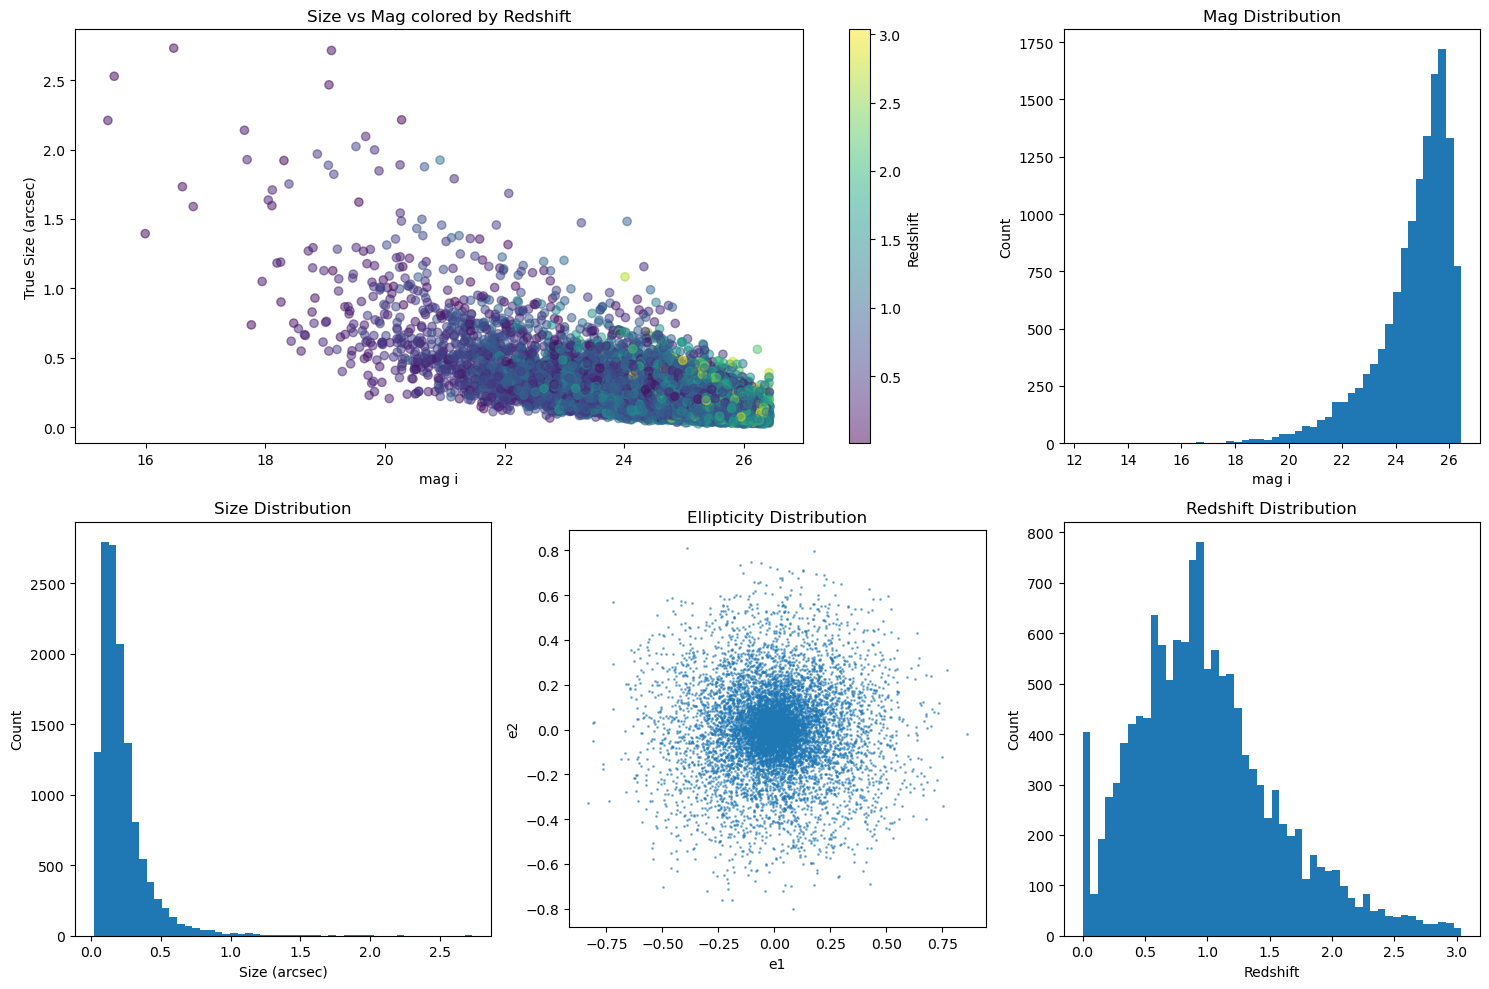

In [70]:
generate_obj_plots(lsst_test_matched_truth)

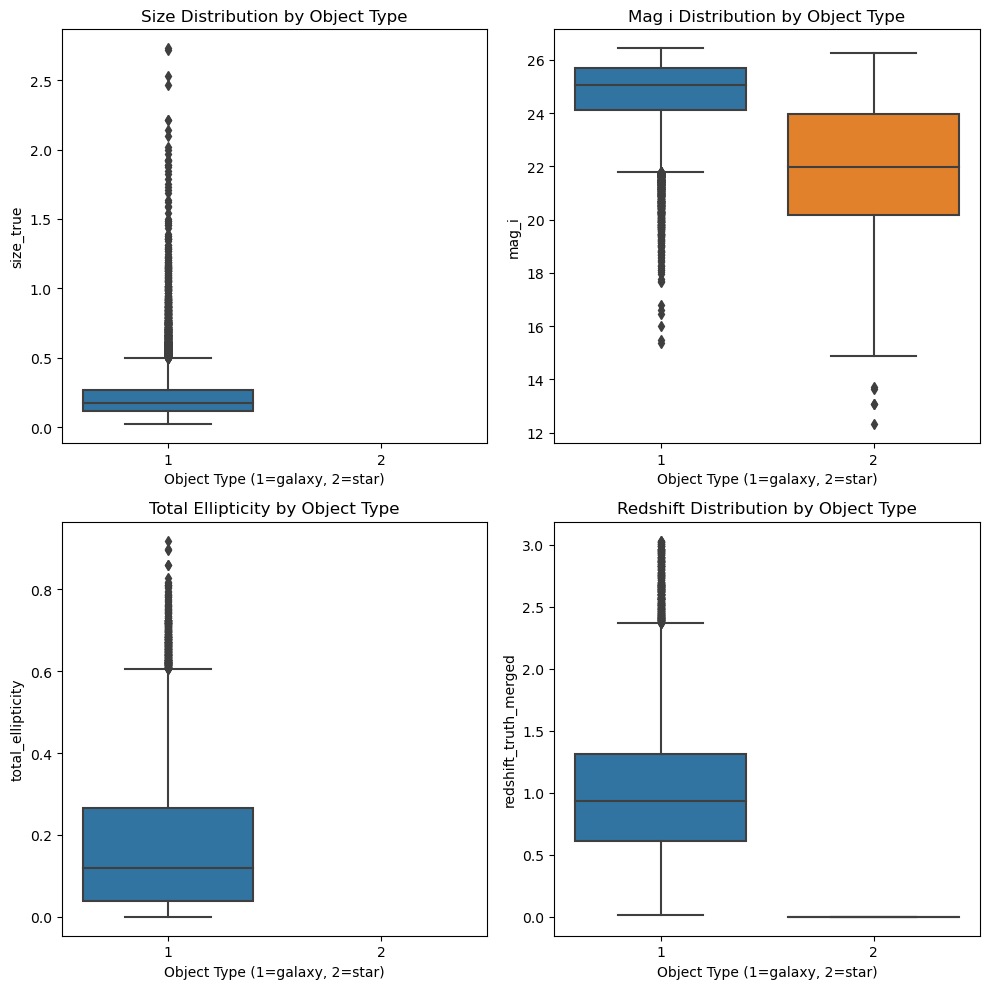

In [76]:
generate_box_plots(lsst_test_matched_truth)

## Matched DeepDISC and LSST Truth Objs

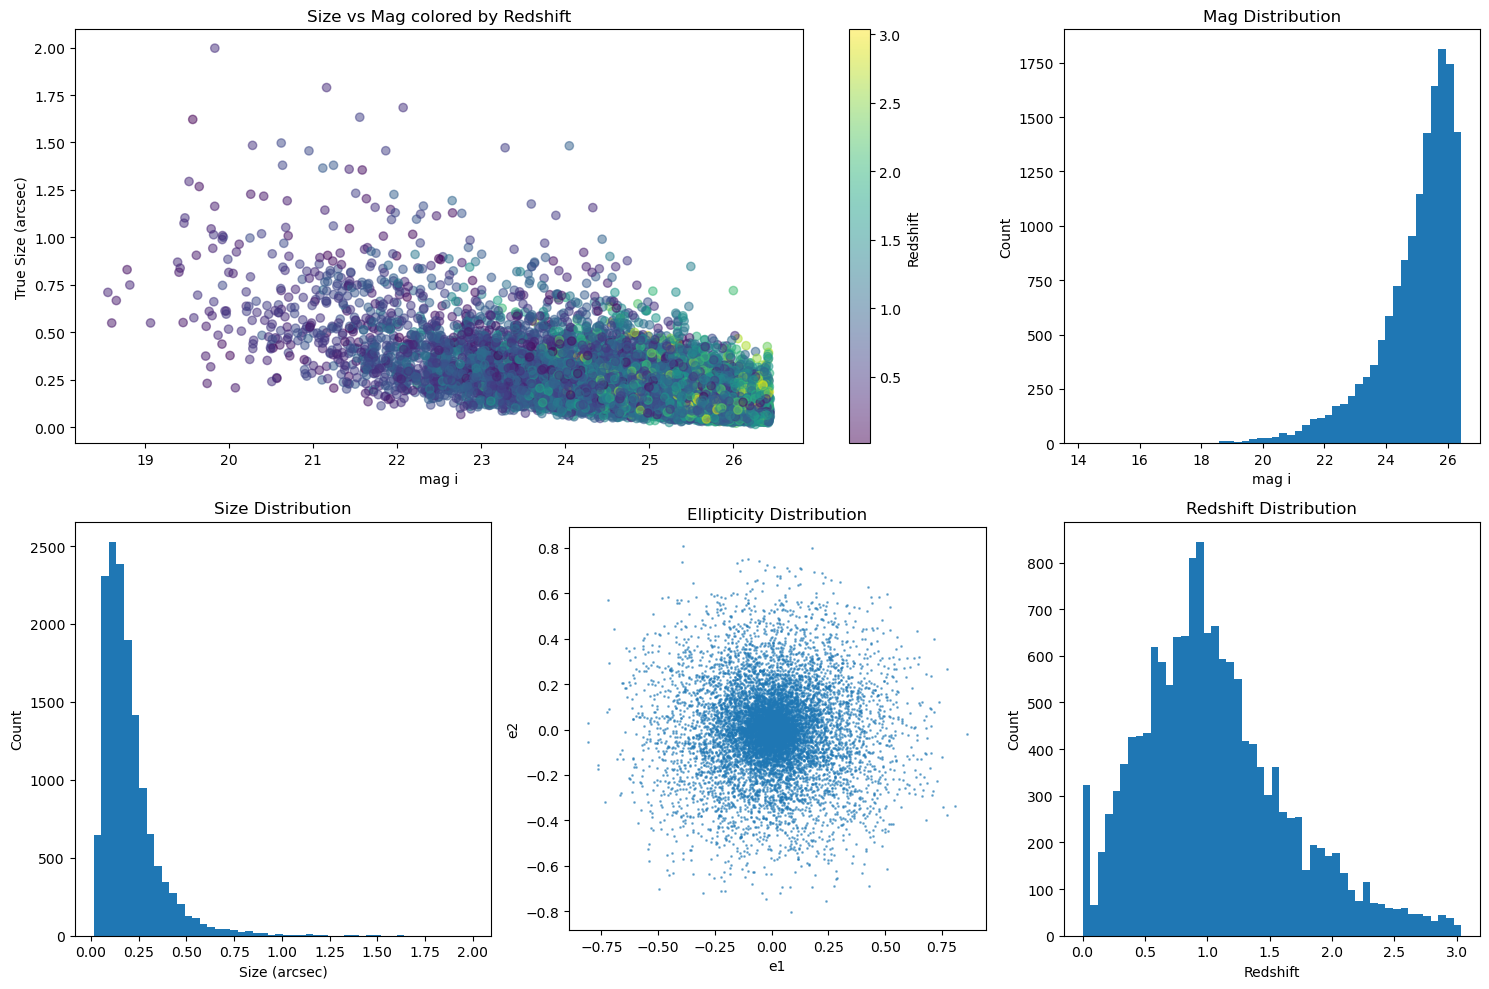

In [68]:
generate_obj_plots(dd_matched_truth)

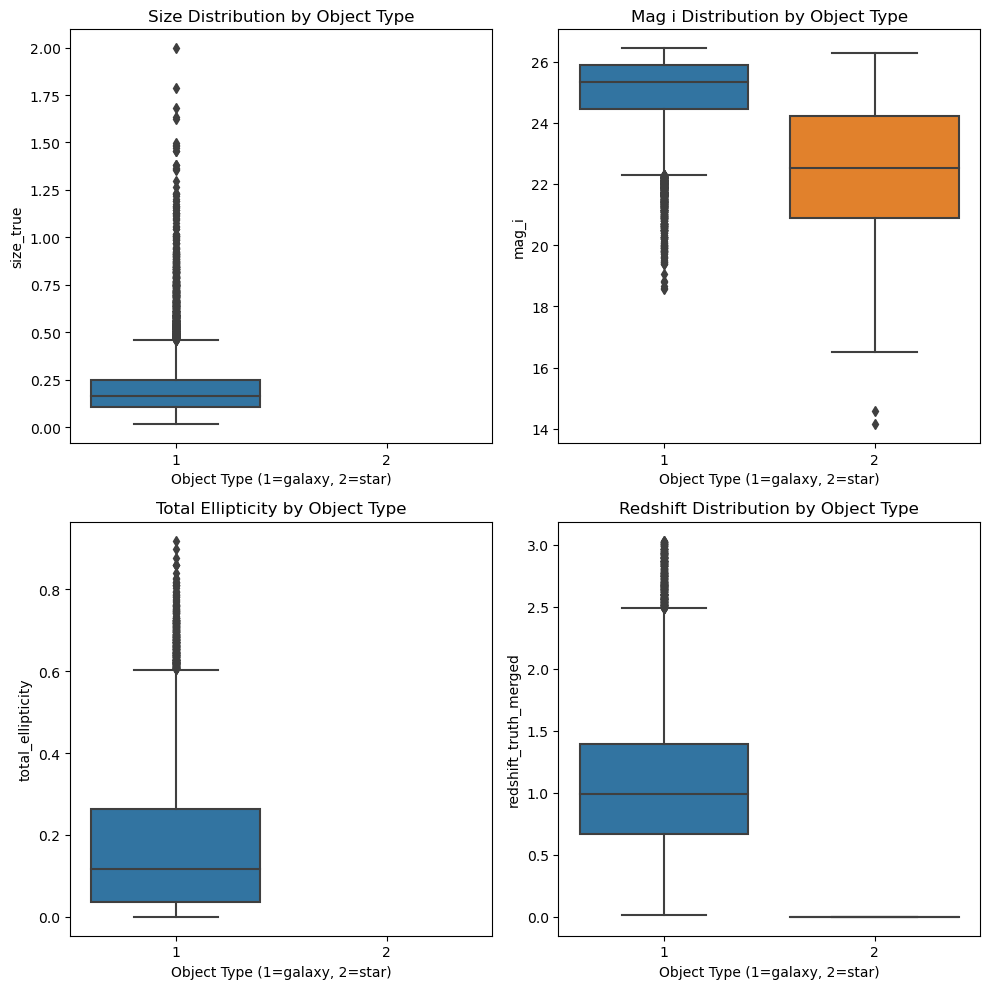

In [77]:
generate_box_plots(dd_matched_truth)

# 2D Histogram FOF Plot

In [13]:
# does same mag cut to truth that detection also has
def get_lsst_cat_ras_decs(lsst_cat, cat_type):
    lsst_df = pd.DataFrame()
    ra_dec_df = None
    if cat_type == 'truth':
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra_truth_merged','dec_truth_merged']]
        ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
        mags = lsst_df['mag_i']
    else: # det catalog
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 27)]
        ra_dec_df = lsst_df[['ra','dec']]
        mags = lsst_df['mag_i']
    return Table.from_pandas(ra_dec_df), list(mags)

In [14]:
import FoFCatalogMatching
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using Friends-of-Friends algorithm.
    
    Parameters:
    -----------
    cat_a, cat_b : astropy.table.Table
        The two catalogs to match.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 0.5.
    max_friends : int or None, optional
        The maximum number of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    # first linking length groups points within that distance, limited by max_friends
    linking_lengths = {linking_length: max_friends}
    # use lsst truth catalog to get 1-1 match with LSST Det/Roman Det to recreat Fig 11 from Troxel Paper     
    return FoFCatalogMatching.match({cat_a_name: cat_a, cat_b_name: cat_b},
                               linking_lengths)

In [15]:
# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def autofit_text(ax, text, x, y):
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        
        # grab the renderer
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        
        # check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        
        t.remove()
        fontsize -= 1

    # if we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')
    
def plot_matches(results, x_axis_name, xlabel, ylabel):
    # now we want to count the number of cat a and cat b objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the x-axis cat (catalog A) and which are from y-axis cat (catalog B)
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # unique, counts = np.unique(n_a, return_counts=True)
    # print("n_a:", dict(zip(unique, counts)))
    # unique2, counts2 = np.unique(n_b, return_counts=True)
    # print("n_b:", dict(zip(unique2, counts2)))

    # now n_a and n_b are the number of cat a/cat b objects in each group
    # we want to make a 2d histrogram of (n_a, n_b). 
    n_max = max(n_a.max(), n_b.max()) + 1
    hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how we want to visualize our histograms
    # hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # how they choose to visualize their histograms
    plt.figure(figsize=(12,10))
    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel}')
    plt.ylabel(f'Number of {ylabel}')
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    ax = plt.gca()
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                text = str(hist_2d[i, j])
                autofit_text(ax, text, j, i)

## DeepDISC vs LSST Det

In [16]:
dd_test_det = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_det11.json')
lsst_test_det = pd.read_json('/home/yse2/lsst_data/annotationsc-ups/lsst_test_det11_cat.json')

lsst_test_det = lsst_test_det.drop_duplicates(subset=['ra', 'dec'])

dd_det_table = Table.from_pandas(dd_test_det)
lsst_test_det_table, test_det_mags = get_lsst_cat_ras_decs(lsst_test_det, cat_type='det')

In [17]:
# cat a will be on x axis
# cat b will be on y axis
cat_a_name = 'lsst_test_det'
cat_b_name = 'dd_det'
dd_det_lsst_det1 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name)
dd_det_lsst_det05 = find_matches(cat_a=lsst_test_det_table, cat_b=dd_test_det,  cat_a_name=cat_a_name, cat_b_name=cat_b_name, linking_length=0.5)

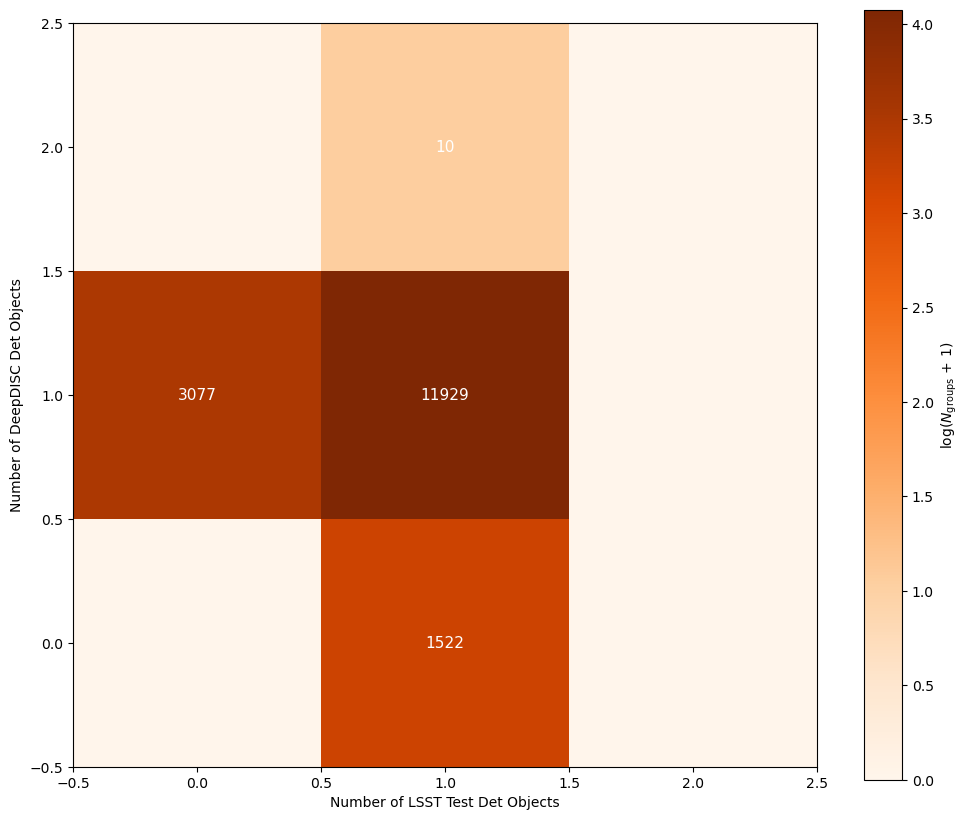

In [18]:
plot_matches(dd_det_lsst_det05, x_axis_name='lsst_test_det', xlabel='LSST Test Det Objects', ylabel='DeepDISC Det Objects')

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u

def get_unmatched_objects(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Extract objects that were detected by DeepDISC but not matched 1-1 with LSST detections
    """
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # groups where LSST has 0 detections and DeepDISC has 1
    target_groups = np.where((n_a == 0) & (n_b == 1))[0]
    
    # grabbing DeepDISC rows in these groups
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = fof_results[dd_mask]['row_index']
    
    # now we use these indices to get full obj props from the matched truth catalog
    unmatched_objects = dd_truth_info.iloc[dd_indices]
    
    return unmatched_objects

def get_unmatched_objects2(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Extract unrecognized blends (LSST - 1 Det and DeepDISC - 2 Det)
    """
    cat_a_mask = fof_results['catalog_key'] == cat_a_name
    cat_b_mask = ~cat_a_mask
    
    n_groups = fof_results['group_id'].max() + 1
    n_a = np.bincount(fof_results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(fof_results['group_id'][cat_b_mask], minlength=n_groups)
    
    # Find groups where LSST has 1 detections and DeepDISC has 2
    target_groups = np.where((n_a == 1) & (n_b == 2))[0]
    
    dd_mask = cat_b_mask & np.isin(fof_results['group_id'], target_groups)
    dd_indices = fof_results[dd_mask]['row_index']
    
    unmatched_objects = dd_truth_info.iloc[dd_indices]
    
    return unmatched_objects

def print_statistics(unmatched_objects):
    """
    Print summary statistics for unmatched objects
    """
    print("\nUnmatched Object Statistics:")
    print("-" * 50)
    print(f"Total number of unmatched objects: {len(unmatched_objects)}")
    
    if 'truth_type' in unmatched_objects.columns:
        type_counts = unmatched_objects['truth_type'].value_counts()
        print("\nObject Type Distribution:")
        for t, count in type_counts.items():
            print(f"{'Galaxy' if t==1 else 'Star'}: {count} ({100*count/len(unmatched_objects):.1f}%)")
    
    print("\nMagnitude Statistics:")
    print(unmatched_objects['mag_i'].describe())
    
    if 'size_true' in unmatched_objects.columns:
        print("\nSize Statistics (arcsec):")
        print(unmatched_objects['size_true'].describe())
    
    print("\nRedshift Statistics:")
    print(unmatched_objects['redshift_truth_merged'].describe())

def analyze_unmatched_objects(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    Main analysis function to extract statistics and plot unmatched objects using existing plotting functions
    """
    unmatched = get_unmatched_objects(fof_results, dd_truth_info, cat_a_name)
    
    print_statistics(unmatched)
    
    # plots with our prev plot funcs
    plt.figure(figsize=(15, 10))
    generate_obj_plots(unmatched)
    plt.figure(figsize=(10, 10))
    generate_box_plots(unmatched)
    
    return unmatched

def analyze_unmatched_objects2(fof_results, dd_truth_info, cat_a_name='lsst_test_det'):
    """
    unrecognized blends plot
    """
    unmatched = get_unmatched_objects2(fof_results, dd_truth_info, cat_a_name)
    print_statistics(unmatched)
    plt.figure(figsize=(15, 10))
    generate_obj_plots(unmatched)
    plt.figure(figsize=(10, 10))
    generate_box_plots(unmatched)
    
    return unmatched


Unmatched Object Statistics:
--------------------------------------------------
Total number of unmatched objects: 3077

Object Type Distribution:
Galaxy: 3060 (99.4%)
Star: 17 (0.6%)

Magnitude Statistics:
count    3077.000000
mean       25.790258
std         0.723845
min        14.141115
25%        25.601597
50%        25.990858
75%        26.236403
max        26.438667
Name: mag_i, dtype: float64

Size Statistics (arcsec):
count    3060.000000
mean        0.161687
std         0.112327
min         0.014233
25%         0.085584
50%         0.134900
75%         0.206578
max         1.633192
Name: size_true, dtype: float64

Redshift Statistics:
count    3077.000000
mean        1.245137
std         0.627498
min         0.000000
25%         0.813334
50%         1.131549
75%         1.599043
max         3.033423
Name: redshift_truth_merged, dtype: float64


/tmp/ipykernel_3232320/1617412409.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truth_cat['total_ellipticity'] = e_tot



Unmatched Object Statistics:
--------------------------------------------------
Total number of unmatched objects: 20

Object Type Distribution:
Galaxy: 18 (90.0%)
Star: 2 (10.0%)

Magnitude Statistics:
count    20.000000
mean     24.802094
std       1.136487
min      22.985430
25%      23.679740
50%      25.128477
75%      25.876402
max      26.300838
Name: mag_i, dtype: float64

Size Statistics (arcsec):
count    18.000000
mean      0.205225
std       0.153316
min       0.039349
25%       0.086631
50%       0.170948
75%       0.281642
max       0.581920
Name: size_true, dtype: float64

Redshift Statistics:
count    20.000000
mean      0.901918
std       0.477260
min       0.000000
25%       0.625992
50%       1.017371
75%       1.174047
max       1.779987
Name: redshift_truth_merged, dtype: float64


/tmp/ipykernel_3232320/1617412409.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truth_cat['total_ellipticity'] = e_tot


<Figure size 1500x1000 with 0 Axes>

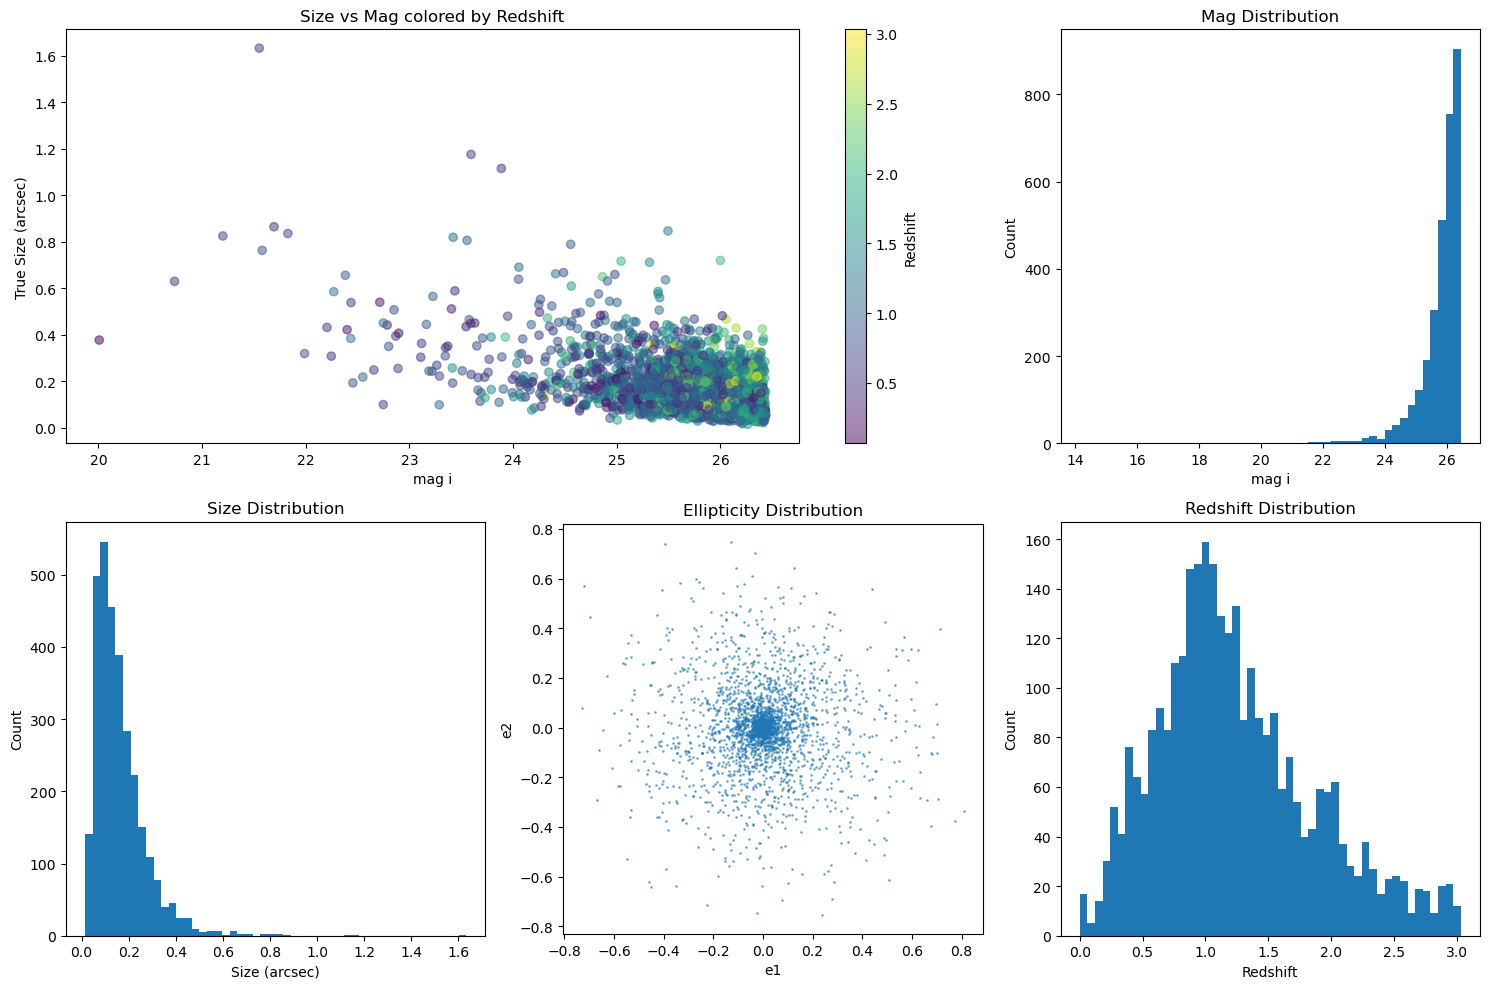

<Figure size 1000x1000 with 0 Axes>

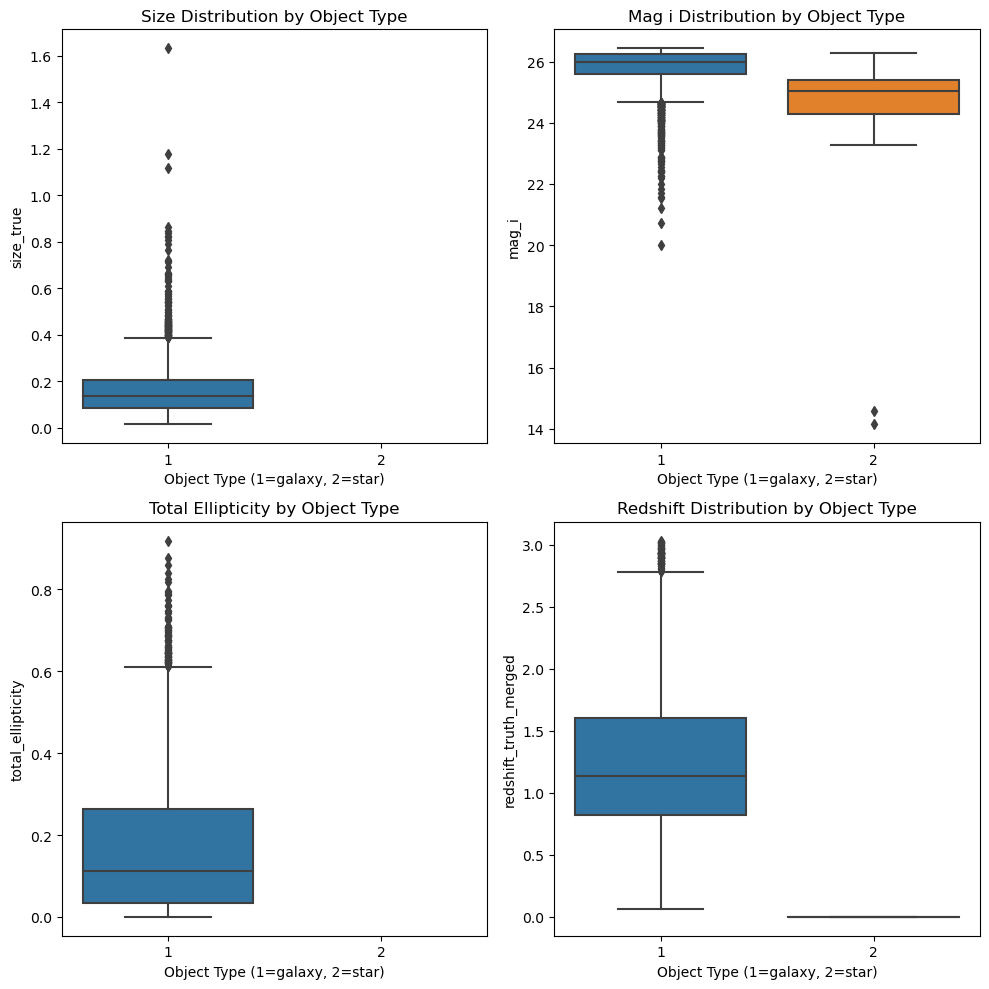

<Figure size 1500x1000 with 0 Axes>

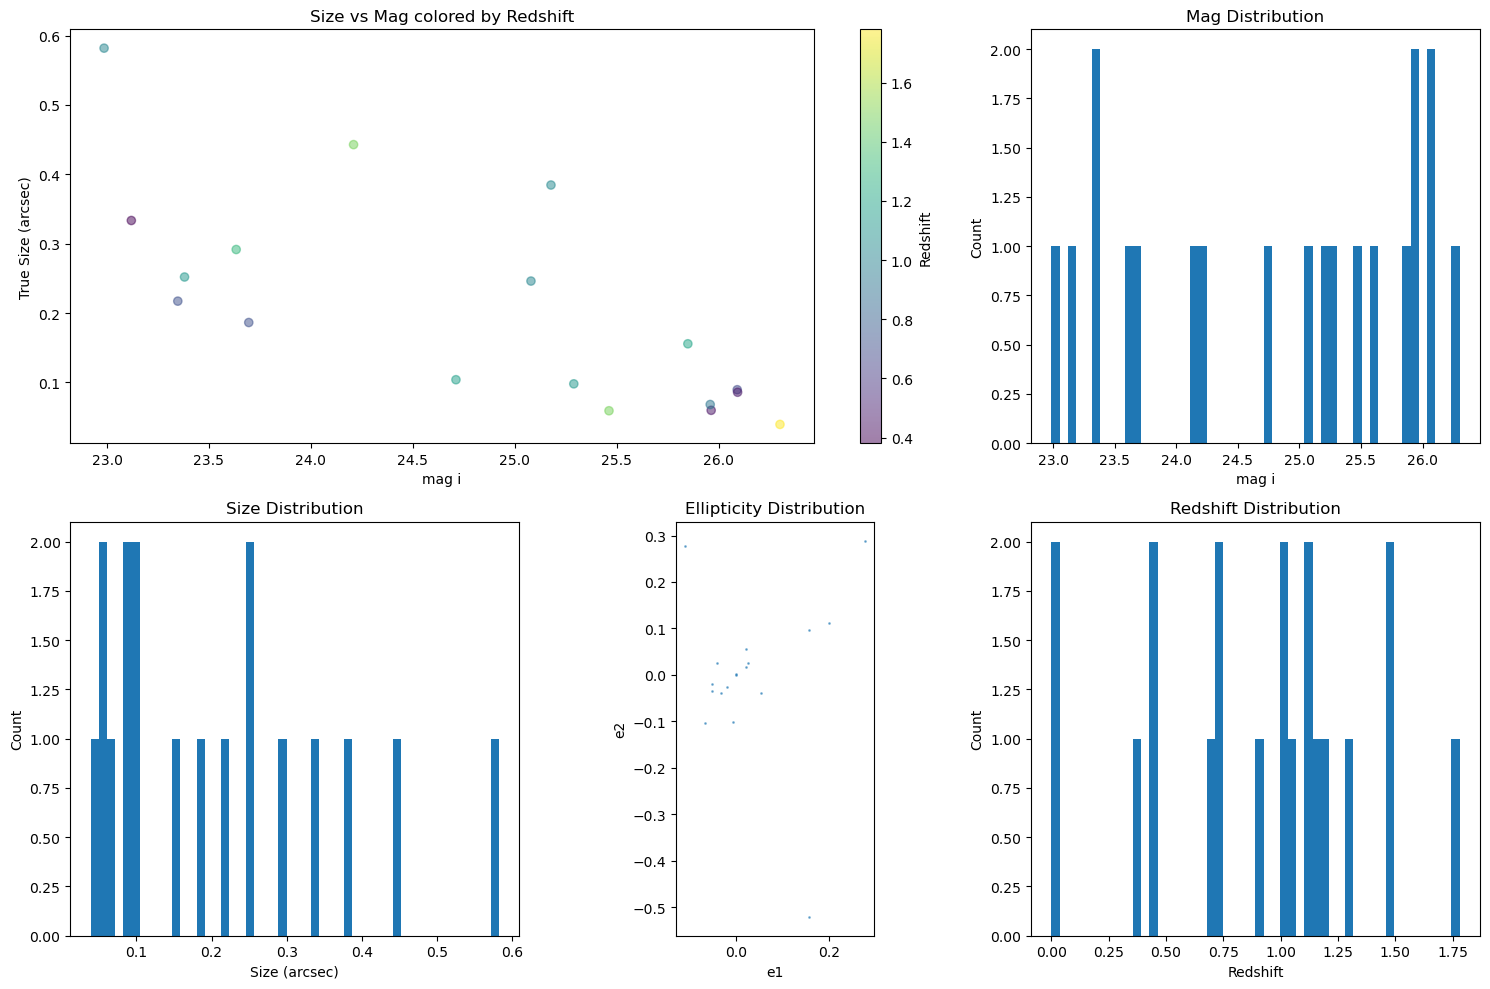

<Figure size 1000x1000 with 0 Axes>

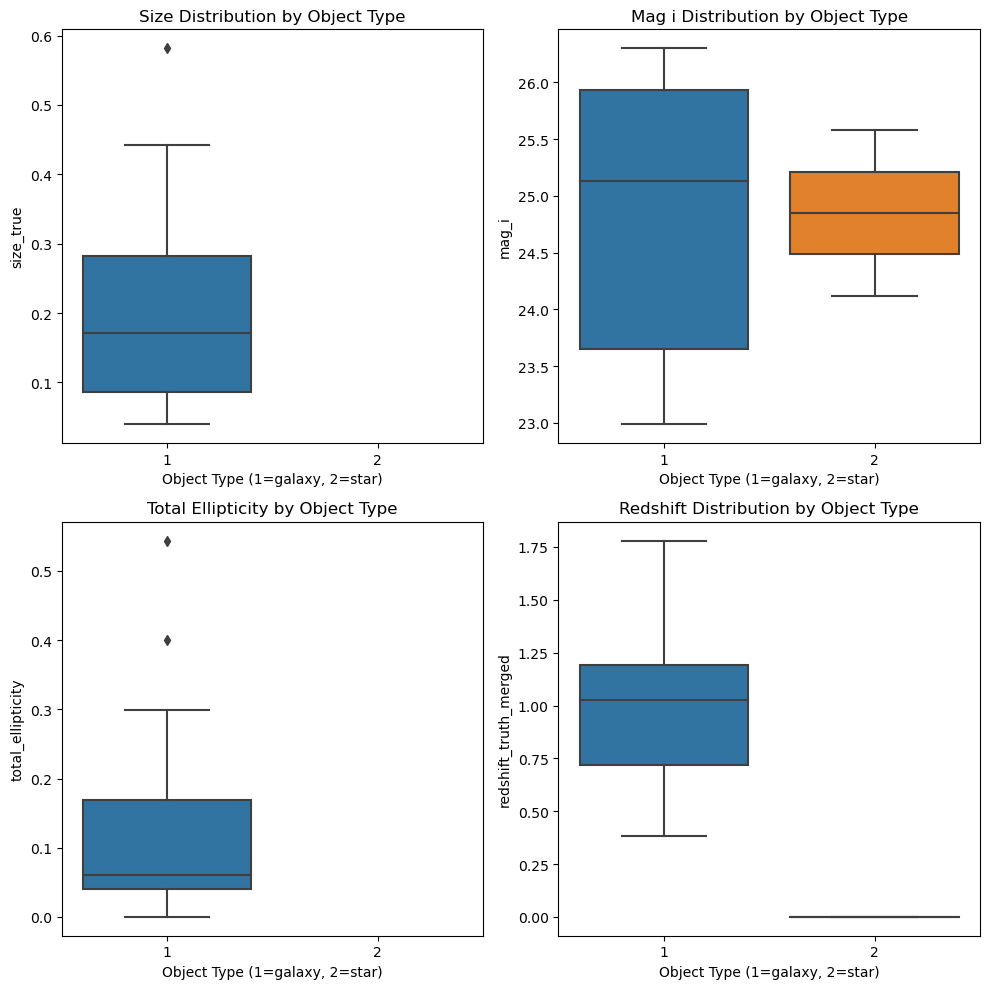

In [20]:
dd_truth_info = pd.read_json('/home/yse2/lsst_runs/run4_ups_roman/dd_test_truth11.json', orient='records')

unmatched_objects = analyze_unmatched_objects(dd_det_lsst_det05, dd_truth_info)
unmatched_objects2 = analyze_unmatched_objects2(dd_det_lsst_det05, dd_truth_info)

# unmatched_objects.to_json('/home/yse2/lsst_runs/run4_ups_roman/unmatched_objects.json', orient='records')

In [29]:
unmatched_objects2

flux_i  cosmodc2_hp       flux_r patch  truth_type       flux_z  \
11936   237.209671        10194   254.118927   1,1           1   222.411194   
11953   752.173035        10194   387.745148   1,1           1  1132.493286   
257    1207.647217        10067   442.520599   2,3           1  1761.857056   
287    1664.104614        10067   661.676208   2,3           1  2261.906250   
8233   2052.767334        10194  1214.401367   5,6           1  2735.241455   
8256    473.613464        10194   399.216522   5,6           1   850.351746   
14143   132.908371        10195    65.916985   5,5           1   155.218826   
14154   818.138245           -1   510.172302   5,5           2  1019.531372   
11913   337.471436        10195   181.507874   5,5           1   591.855042   
11933  2321.819824        10195  1521.536255   5,5           1  3651.698975   
9671    278.089630        10066   285.363464   3,0           1   378.402557   
9682    149.510941        10066   111.773193   3,0           1   174.937515   
7475    308.305023        10066   208.409119   3,0           1   501.163879   
7481    213.131180           -1   107.202019   3,0           2   292.185699   
5816   1278.185547        10066  1289.143555   3,0           1  1554.382568   
5842   1614.201904        10066  1107.700806   3,0           1  3237.242676   
8854    132.680481        10195    95.464806   4,0           1   160.803101   
8858    166.111343        10195   126.811783   4,0           1   345.484192   
3506    109.563225         9939   123.888000   3,1           1    99.314026   
3518    150.161453         9939    61.813713   3,1           1   253.889450   

       cosmodc2_id  tract      mag_y      mag_r  ...  ellipticity_2_true  \
11936  10255195150   3256  25.171066  25.387405  ...           -0.026717   
11953  10255195146   3256  22.960264  24.928635  ...            0.097671   
257     9501017961   3257  23.024178  24.785166  ...           -0.520872   
287     9501017963   3257  22.796810  24.348385  ...            0.278379   
8233   10250190279   3076  22.604626  23.689095  ...            0.026259   
8256   10253351522   3076  23.904236  24.896980  ...            0.000015   
14143  10313489927   3077  25.796928  26.852509  ...           -0.038179   
14154           -1   3077  23.751995  24.630709  ...                 NaN   
11913  10315007559   3077  24.379377  25.752762  ...           -0.101694   
11933  10315033895   3077  22.334545  23.444294  ...            0.017016   
9671    9440680857   3442  24.985315  25.261505  ...           -0.019039   
9682    9437860905   3442  25.684921  26.279156  ...            0.026232   
7475    9440085390   3442  24.630951  25.602707  ...           -0.103524   
7481            -1   3442  25.062790  26.324492  ...                 NaN   
5816    9441511063   3442  23.083424  23.624247  ...           -0.038207   
5842    9440569669   3442  22.423031  23.788944  ...            0.055441   
8854   10312814642   3258  25.737703  26.450390  ...            0.288963   
8858   10315862461   3258  24.816967  26.142101  ...            0.111656   
3506    8695044047   3633  26.486380  26.167427  ...            0.002316   
3518    8689432416   3633  25.198734  26.922287  ...           -0.034687   

       position_angle_true_dc2  ra_cosmodc2  mag_true_u  redshift_cosmodc2  \
11936               151.886565    51.258101   25.150358           1.483264   
11953               118.845623    51.257937   25.994892           1.484069   
257                  12.275994    52.855942   27.740499           0.719465   
287                 138.022656    52.855896   26.264400           0.718882   
8233                123.399205    53.183604   27.043819           0.381085   
8256                107.086146    53.183337   24.901548           1.166121   
14143                76.100521    54.984501   28.424171           0.681128   
14154                      NaN          NaN         NaN                NaN   
11913               172.458966    55.121002   26.3222

In [28]:
predictions

ra        dec  image_id         subpatch  \
0      51.455104 -38.333808       108  dc2_51.37_-38.3   
1      51.457344 -38.340552       108  dc2_51.37_-38.3   
2      51.460527 -38.336425       108  dc2_51.37_-38.3   
3      51.463617 -38.339841       108  dc2_51.37_-38.3   
4      51.456590 -38.333785       108  dc2_51.37_-38.3   
...          ...        ...       ...              ...   
22258  51.606762 -40.017086       271  dc2_51.53_-40.0   
22259  51.602480 -40.012588       271  dc2_51.53_-40.0   
22260  51.604582 -40.012850       271  dc2_51.53_-40.0   
22261  51.603522 -40.011364       271  dc2_51.53_-40.0   
22262  51.603318 -40.013893       271  dc2_51.53_-40.0   

                                               file_name  
0      ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c1...  
1      ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c1...  
2      ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c1...  
3      ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c1...  
4      ./lsst_data/truthc-ups/dc2_51.37_-38.3/full_c1...  
...                                                  ...  
22258  ./lsst_data/truthc-ups/dc2_51.53_-40.0/full_c2...  
22259  ./lsst_data/truthc-ups/dc2_51.53_-40.0/full_c2...  
22260  ./lsst_data/truthc-ups/dc2_51.53_-40.0/full_c2...  
22261  ./lsst_data/truthc-ups/dc2_51.53_-40.0/full_c2...  
22262  ./lsst_data/truthc-ups/dc2_51.53_-40.0/full_c2...  

[22263 rows x 5 columns]

In [41]:
def get_unrec_blend_imgs(unmatched_objects2, predictions, max_sep=0.5):
    ras = unmatched_objects2.ra_truth_merged.values
    decs = unmatched_objects2.dec_truth_merged.values
    coord = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    
    ras_2 = predictions.ra.values
    decs_2 = predictions.dec.values
    allcatalog = SkyCoord(ra=ras_2*u.degree, dec=decs_2*u.degree)
   
    idx, d2d, _ = coord.match_to_catalog_sky(allcatalog)
    print(d2d)
#     good_sep = d2d < max_sep
    # count how many objs match to each unrec blends and keep 1-to-1 matches
    unique_preds, pred_counts = np.unique(idx, return_counts=True)
    good_pred = unique_preds[pred_counts == 1]
    
    final_mask = good_sep & np.isin(idx, good_pred)
    matched_unm_indices = np.where(final_mask)[0]
    matched_pred_indices = idx[final_mask]
    
    matched_unm = unmatched_objects2.iloc[matched_unm_indices].copy()
    matched_preds = predictions.iloc[matched_pred_indices].copy()
    
    print(f"Found {len(matched_unm)} matched pairs")
#     return comp

In [42]:
get_unrec_blend_imgs(unmatched_objects2, predictions)

[0d00m00.34831172s 0d00m00.08099383s 0d00m00.17549842s 0d00m00.20560849s
 0d00m00.437963s 0d00m00.04214872s 0d00m00.40707244s 0d00m00.30256709s
 0d00m00.4218103s 0d00m00.33859127s 0d00m00.25784358s 0d00m00.39321465s
 0d00m00.15747318s 0d00m00.20475506s 0d00m00.18706119s 0d00m00.34442796s
 0d00m00.25146716s 0d00m00.27723588s 0d00m00.21549484s 0d00m00.49051557s]


UnitConversionError: Can only apply 'less' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)